In [1]:
import numpy as np
import pandas as pd
import numexpr
import itertools
from subprocess import call

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

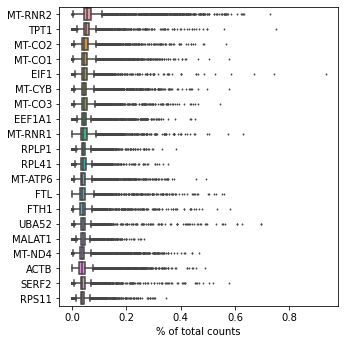

In [2]:
# DATA PROCESSING https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html?msclkid=9d2e34bcd04011ecb94b3611e5706065

import scanpy as sc
import os

if not os.path.isdir(r"data"):
    sc.datasets.pbmc3k()

adata = sc.read_h5ad("/mnt/biocluster/praktikum/neapss22/TS_Vasculature.h5ad")
outdataname = "TS_Vascluature"
#adata = sc.read_h5ad(r"data/pbmc3k_raw.h5ad")
sc.pl.highest_expr_genes(adata, n_top=20)

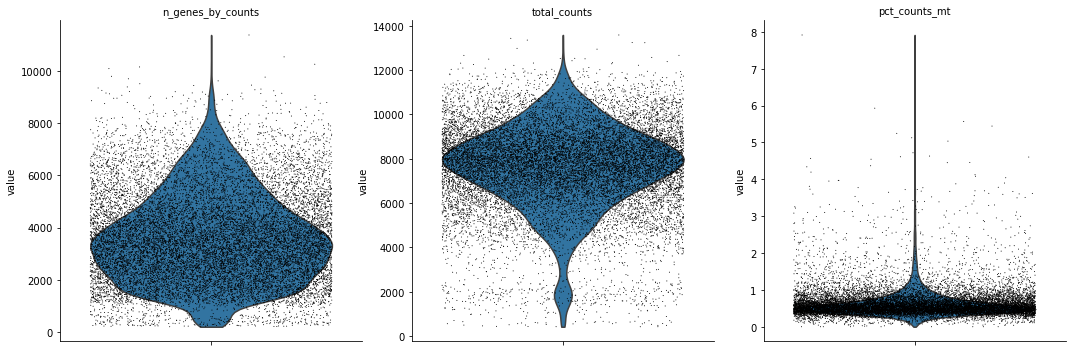

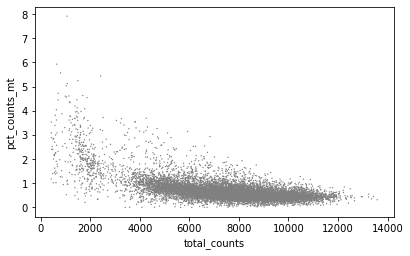

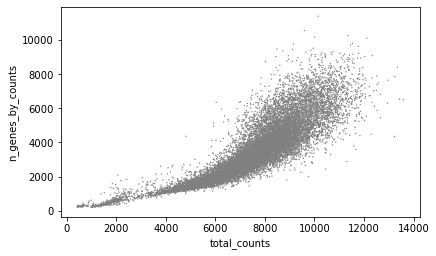

In [3]:
# filter genes

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


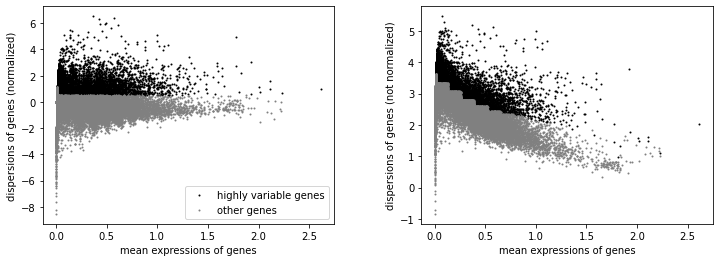

In [4]:
# slicing


adata = adata[adata.obs.n_genes_by_counts < 2000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
# Normalize by X to 10,000 reads per cell (count comparable)

sc.pp.normalize_total(adata, target_sum=1e4)

# logarithmize

sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [5]:
# saving the raw data, then filtering

adata.raw = adata

adata = adata[:, adata.var.highly_variable]

In [6]:
# Regress out effects of total counts and percentage of mitochondrial genes expressed. Scaling data to unit variance
adata = adata.copy()
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

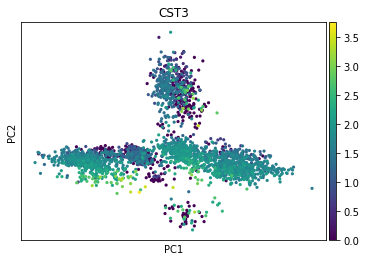

In [7]:
# PCA

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')

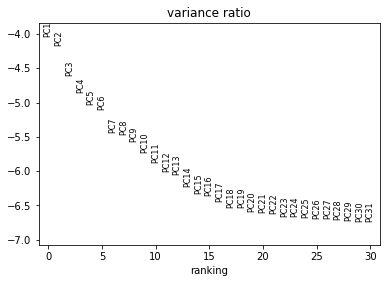

In [8]:
# elbow method

sc.pl.pca_variance_ratio(adata, log=True)

In [9]:
# Neighbourhood graph

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


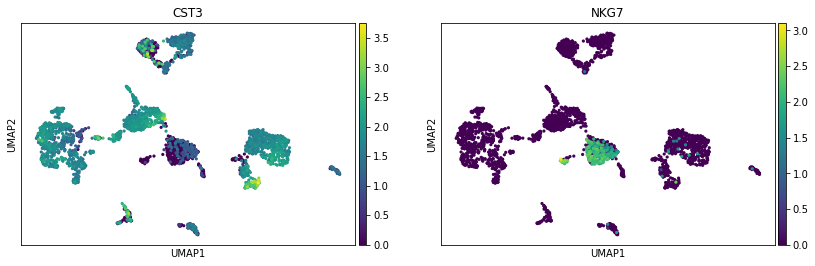

In [10]:
# UMAP data

sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7'])

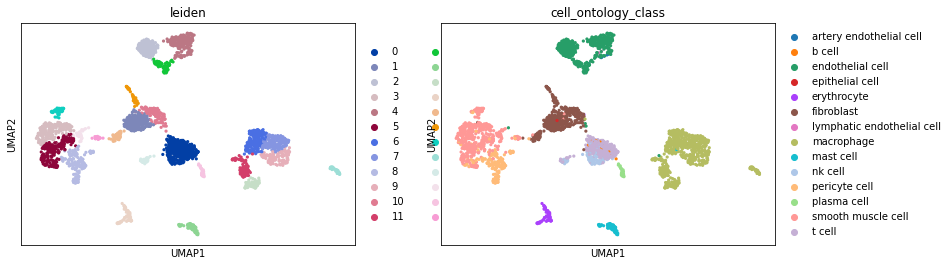

In [11]:
# Clustering

sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'cell_ontology_class'])

/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

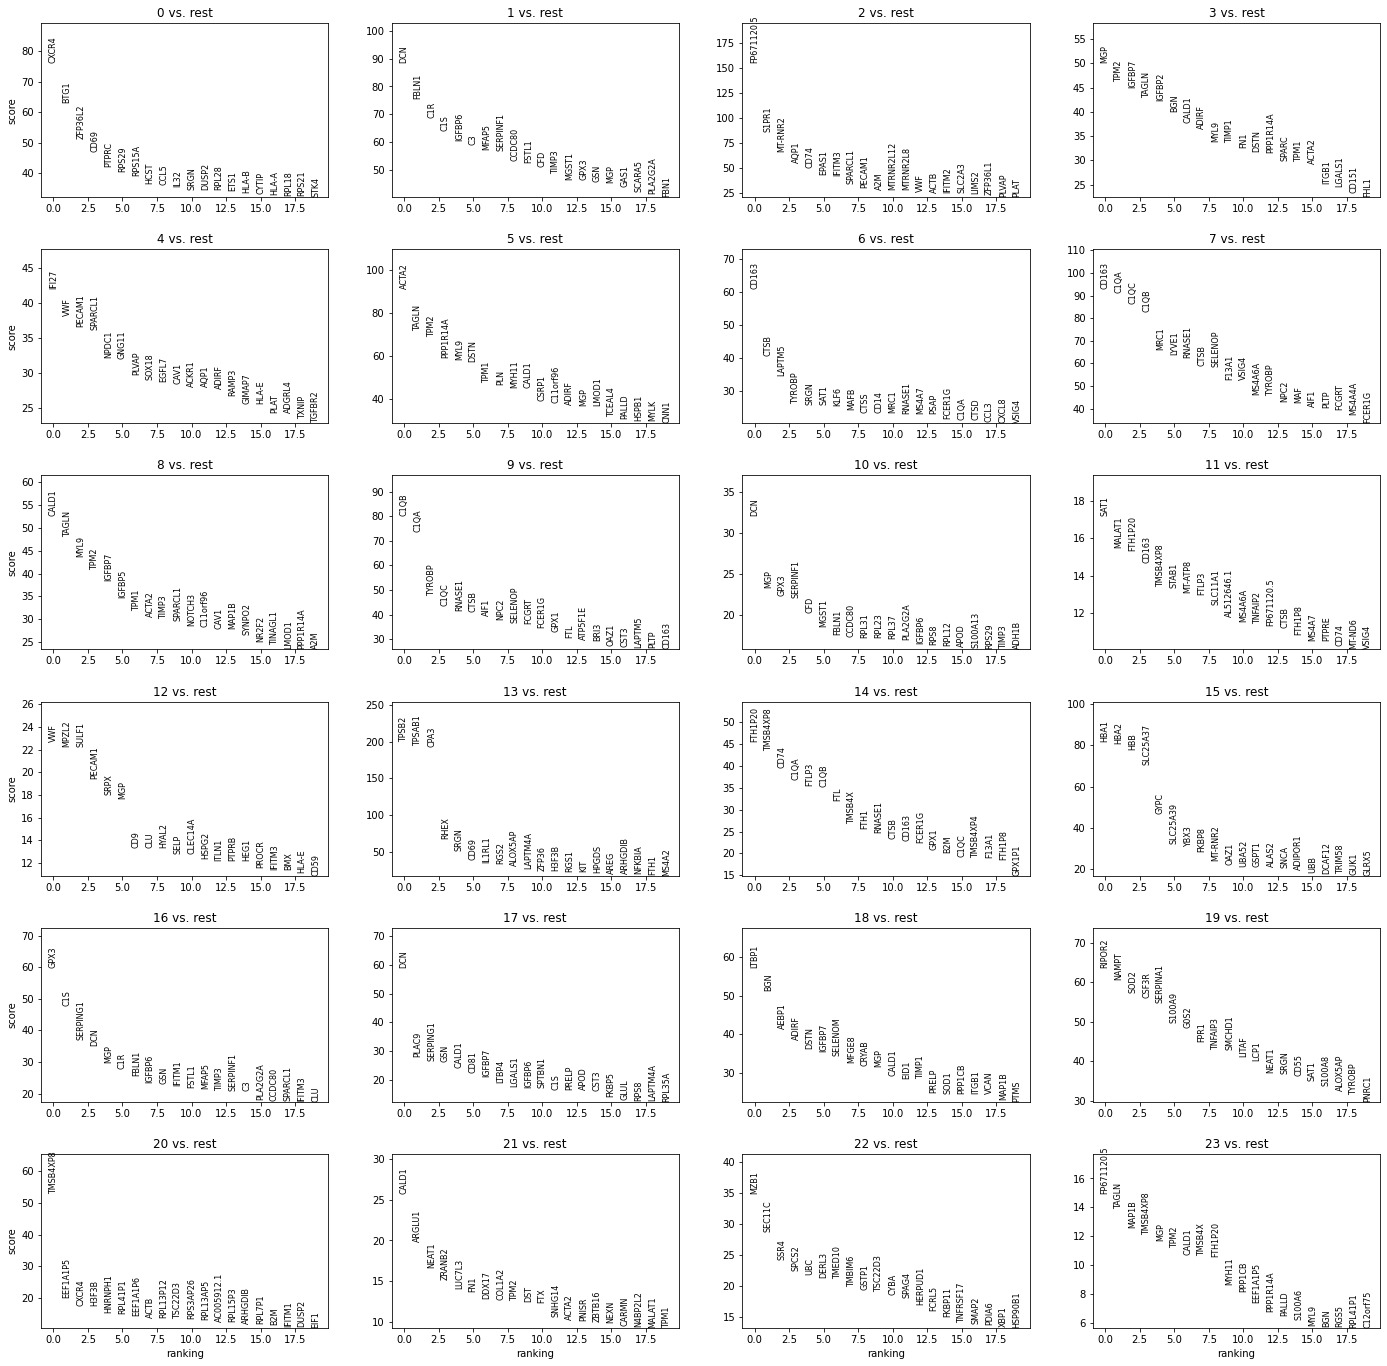

In [12]:
# Finding marker genes ==> t-test

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

ranking genes


/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Perform

    finished (0:00:11)


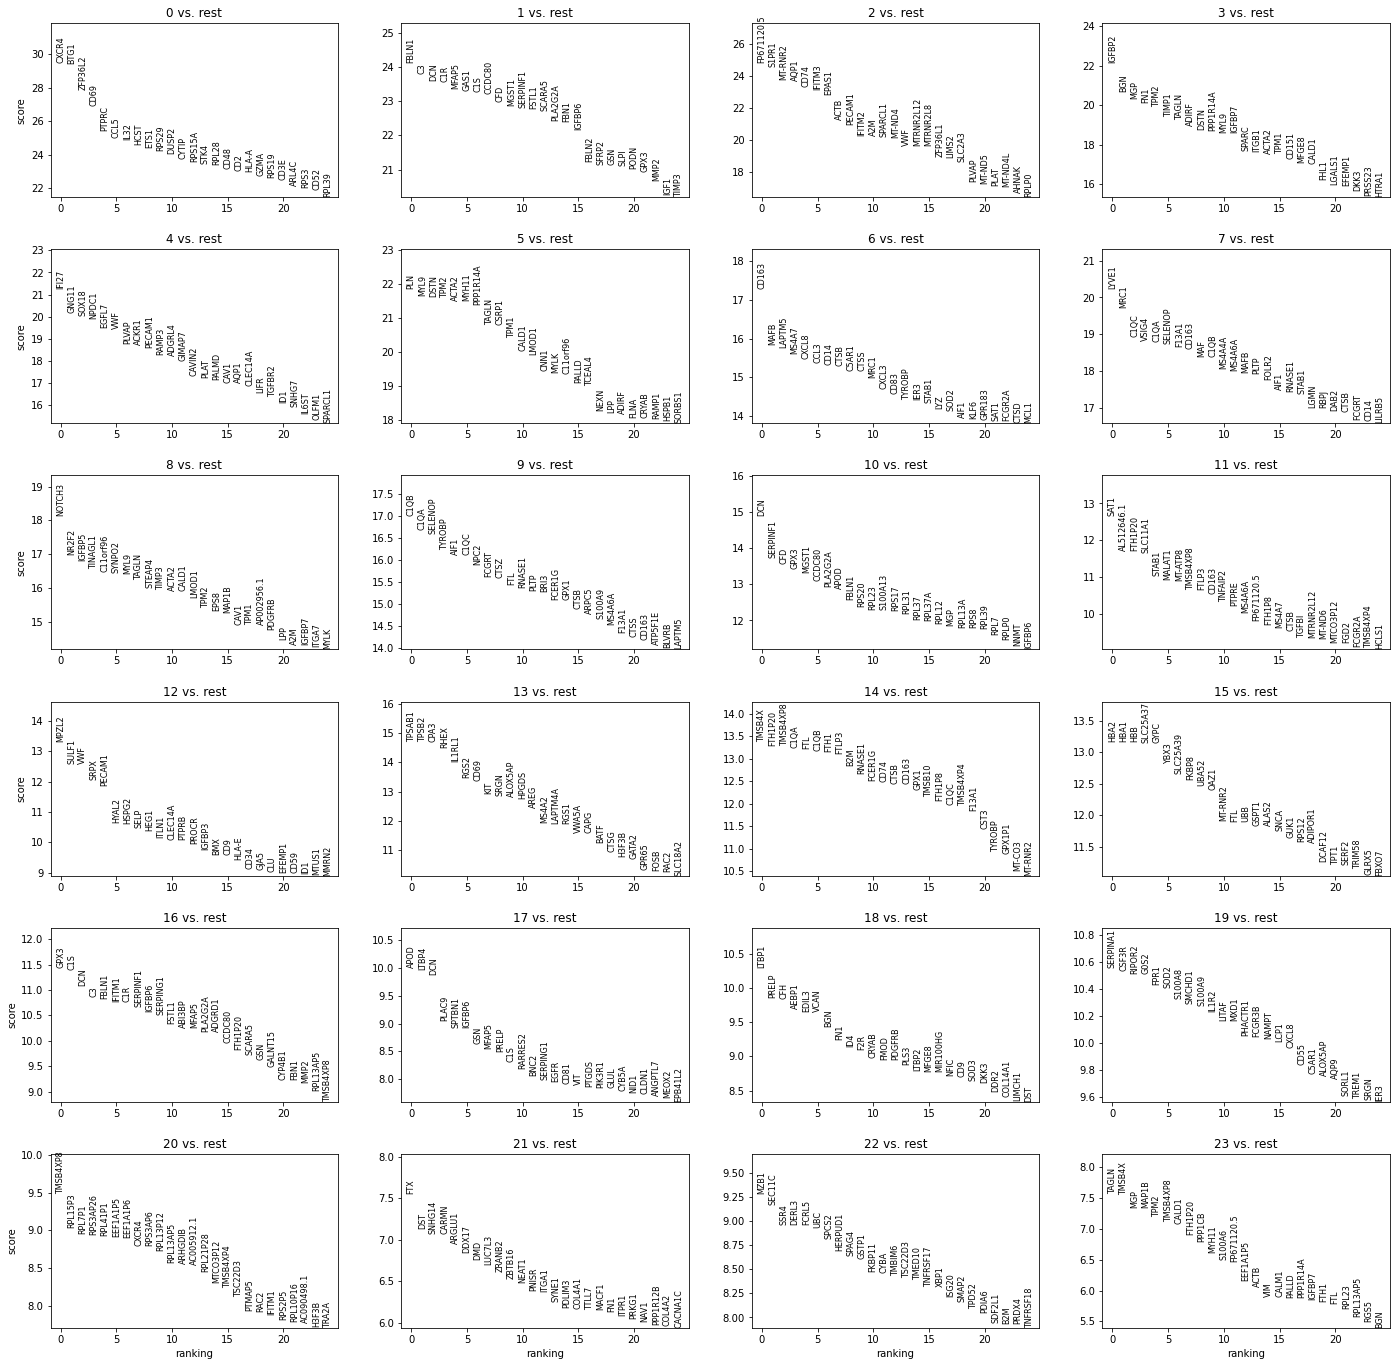

In [13]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished (0:00:26)


/home/c/cho/anaconda3/envs/NSForest/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


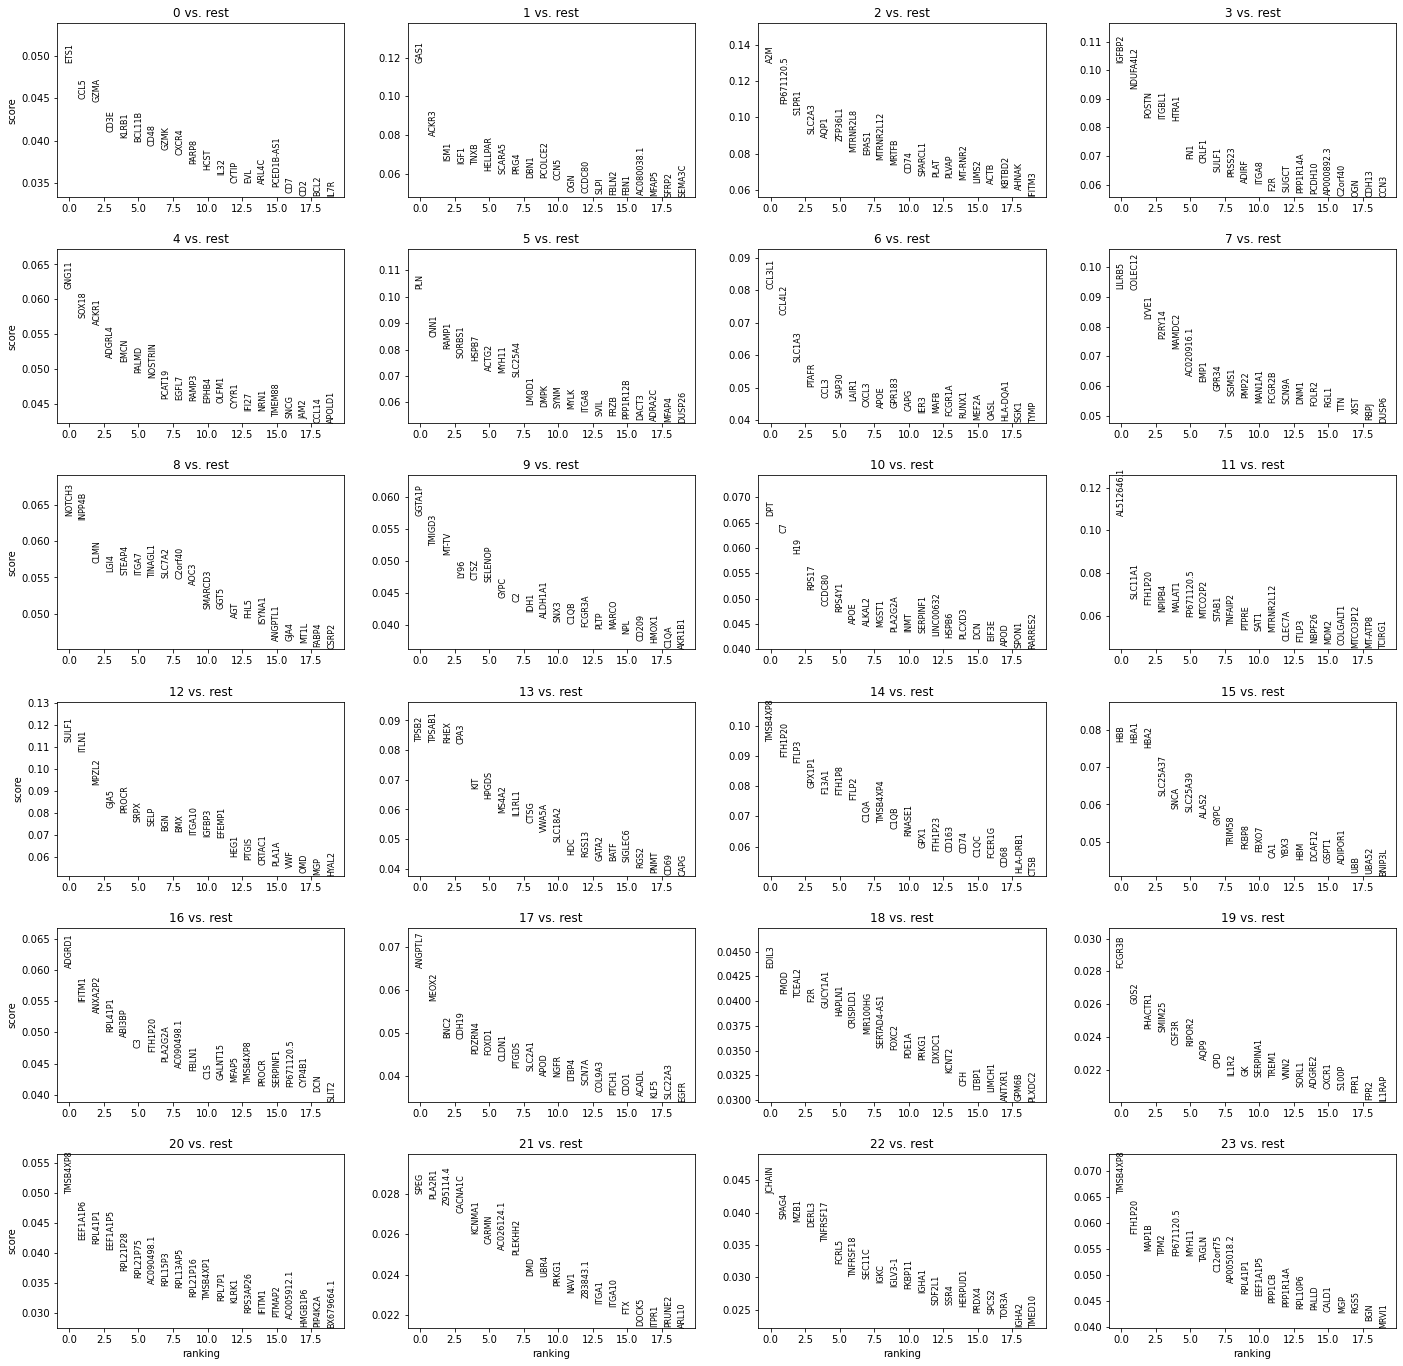

In [14]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [19]:
adata_macrophage = adata[adata.obs.cell_ontology_class == 'macrophage']
adata_macrophage

View of AnnData object with n_obs × n_vars = 658 × 7590
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue

In [21]:
import graphviz
from NSForest_v3 import *
adata_markers_macrophage = NS_Forest(adata_macrophage, 'leiden')

6
6
CCL3L1
2.4558041095733643
CCL4L2
2.265251636505127
LYVE1
-0.3072684407234192
Is Right Out!
F13A1
1.4091678857803345
FTL
0.5348933935165405
RNASE1
1.3167595863342285
VSIG4
1.5931344032287598
COLEC12
-0.37788107991218567
Is Right Out!
PEPD
-0.5127798914909363
Is Right Out!
SCN9A
-0.23347550630569458
Is Right Out!
C1QA
1.5517024993896484
FOLR2
-0.33437415957450867
Is Right Out!
C1QC
1.5980777740478516
ACTB
0.19728432595729828
C1QB
1.5510157346725464
['CCL3L1', 'CCL4L2', 'F13A1', 'FTL', 'RNASE1', 'VSIG4', 'C1QA', 'C1QC', 'ACTB', 'C1QB']
63


/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

7
LYVE1
2.564354181289673
LILRB5
3.0331099033355713
COLEC12
2.7363734245300293
F13A1
2.131627321243286
CCL3L1
-0.3752792477607727
Is Right Out!
FOLR2
2.317009210586548
P2RY14
-0.2189376801252365
Is Right Out!
VSIG4
2.081817150115967
LGMN
1.8939682245254517
CCL4L2
-0.41206809878349304
Is Right Out!
C1QC
2.0046865940093994
RNASE1
1.5652050971984863
C1QA
1.897712230682373
MT-ND2
0.5537116527557373
PLTP
1.7886145114898682
['LYVE1', 'LILRB5', 'COLEC12', 'F13A1', 'FOLR2', 'VSIG4', 'LGMN', 'C1QC', 'RNASE1', 'C1QA', 'MT-ND2', 'PLTP']
63


/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

9
FTL
1.1626973152160645
ATP5F1E
1.0760952234268188
RPS12
0.7576462626457214
GYPC
1.3100428581237793
TMSB4XP8
-0.3993833661079407
Is Right Out!
GGTA1P
2.5509464740753174
YBX1
1.0271685123443604
RPL21
0.6495298147201538
UBA52
0.7901647090911865
FTH1P20
-0.3793858289718628
Is Right Out!
BLVRB
1.5906836986541748
CREG1
1.7584788799285889
C1QA
2.0699548721313477
FTH1P8
-0.3537141978740692
Is Right Out!
C1QC
2.1412949562072754
['FTL', 'ATP5F1E', 'RPS12', 'GYPC', 'GGTA1P', 'YBX1', 'RPL21', 'UBA52', 'BLVRB', 'CREG1', 'C1QA', 'C1QC']
63


/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

10
SHISA4
6.2620415687561035
CELA1
10.0
TRAK2
4.477945804595947
NCS1
6.808342933654785
C2
6.595417499542236
CCL18
9.129749298095703
TFPI
2.6718122959136963
EPC2
5.35817813873291
DAP
4.342080116271973
SLC39A11
7.4371771812438965
FXYD1
5.6440277099609375
BSG
3.3795692920684814
ATP5F1E
3.7433407306671143
WLS
4.545401096343994
RPS12
3.7629873752593994
['SHISA4', 'CELA1', 'TRAK2', 'NCS1', 'C2', 'CCL18', 'TFPI', 'EPC2', 'DAP', 'SLC39A11', 'FXYD1', 'BSG', 'ATP5F1E', 'WLS', 'RPS12']
63


/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

11
AL512646.1
4.102651596069336
NPIPB4
1.5241665840148926
FP671120.5
1.5439221858978271
ATP5F1E
-1.2135379314422607
Is Right Out!
MTRNR2L12
1.0726163387298584
TMSB4XP8
2.6397054195404053
MTCO2P2
2.25773024559021
MT-ATP8
1.460326910018921
RPS12
-1.0671446323394775
Is Right Out!
PTMAP2
-0.17993050813674927
Is Right Out!
MTCO2P12
1.0137646198272705
FTH1P20
3.25968074798584
MTCO3P12
1.6032524108886719
FTH1P7
2.3135461807250977
EEF1A1P5
1.2482917308807373
['AL512646.1', 'NPIPB4', 'FP671120.5', 'MTRNR2L12', 'TMSB4XP8', 'MTCO2P2', 'MT-ATP8', 'MTCO2P12', 'FTH1P20', 'MTCO3P12', 'FTH1P7', 'EEF1A1P5']
63


/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

14
TMSB4XP8
3.817054033279419
RNASE1
2.2908055782318115
FTLP3
4.011362075805664
FTH1P20
3.9213311672210693
GPX1
2.096282958984375
AC108472.1
-0.12399566918611526
Is Right Out!
RPS27AP8
-0.0888412818312645
Is Right Out!
C1QA
2.858480453491211
AL133352.1
-0.0796797052025795
Is Right Out!
AC063924.1
-0.08184540271759033
Is Right Out!
MAP2K3
-0.6300678849220276
Is Right Out!
AC092139.2
-0.19252297282218933
Is Right Out!
AC113385.1
-0.0692339614033699
Is Right Out!
AL121987.2
-0.1141284704208374
Is Right Out!
AC010480.1
-0.0948881134390831
Is Right Out!
['TMSB4XP8', 'RNASE1', 'FTLP3', 'FTH1P20', 'GPX1', 'C1QA']
63


/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

19
ADGRG3
8.203261375427246
TAGLN
0.6355563402175903
TPM2
0.6334641575813293
SLC25A37
2.1207680702209473
YPEL3
1.7862143516540527
R3HDM4
2.8167550563812256
LRG1
4.8168230056762695
BCL6
1.968923807144165
IVNS1ABP
2.8005080223083496
MYH11
-0.41302722692489624
Is Right Out!
ECE1
0.7352335453033447
PHACTR1
3.895615577697754
USP10
2.9158246517181396
CD163
0.13603776693344116
RALGAPA2
2.373674154281616
['ADGRG3', 'TAGLN', 'TPM2', 'SLC25A37', 'YPEL3', 'R3HDM4', 'LRG1', 'BCL6', 'IVNS1ABP', 'ECE1', 'PHACTR1', 'USP10', 'CD163', 'RALGAPA2']
63


/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

                                                 index  f-measure  \
189                         10&TFPI>=2.364456057548523   1.000000   
191                        10&TRAK2>=4.197106242179871   1.000000   
192                         10&EPC2>=4.736275911331177   1.000000   
193                       10&SHISA4>=5.725174188613892   1.000000   
194                         10&NCS1>=5.805999517440796   1.000000   
..                                                 ...        ...   
183  9&GYPC>=1.2871423363685608&RPL21>=0.6646643280...   0.416667   
186  9&GYPC>=1.2871423363685608&RPS12>=0.7029423713...   0.416667   
185  9&GYPC>=1.2871423363685608&RPL21>=0.6646643280...   0.397727   
188  9&GYPC>=1.2871423363685608&RPL21>=0.6646643280...   0.377907   
130                         9&BLVRB>=1.108090102672577   0.353186   

     True Negative  False Positive  False Negative  True Positive  \
189          657.0             0.0             0.0            1.0   
191          657.0             0.

In [40]:
from NSForest_v3_mod import *
adata_endo = adata[adata.obs.cell_ontology_class == 'endothelial cell']
adata_markers_endo = NS_Forest(adata_endo, 'leiden')
Markers_endo = list(itertools.chain.from_iterable(adata_markers_endo['NSForest_Markers'])) #gets list of minimal markers from dataframe for display in scanpy plotting functions
Binary_Markers_endo = list(itertools.chain.from_iterable(adata_markers_endo['Binary_Genes'])) #gets list of binary markers from dataframe for display in scanpy plotting functions
for c, i in enumerate(Markers_endo):
    if i not in Binary_Markers_endo:
        print(f"{c} and {i}")

Markers_endo.remove("FP671120-5")
Markers_endo.append("FP671120.5")

import matplotlib.pyplot as plt
import pandas as pd

dotplot_values = pd.read_csv("NSForest3_medianValues.csv")
#ordered_cluster = [0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,3,4,5,6,7,8,9]
#dotplot_values["Cluster"] = ordered_cluster
dotplot_values.rename(columns = {'Unnamed: 0': "Cluster"}, inplace= True)
dotplot_values.set_index('Cluster', inplace=True)
dotplot_values

6
1
ITSN1
-0.955966055393219
Is Right Out!
FRK
-0.2834012508392334
Is Right Out!
RPS29P5
0.06862057000398636
RN7SL655P
-0.06857873499393463
Is Right Out!
IGKV1-5
0.10386525839567184
FPGS
-0.29985591769218445
Is Right Out!
CUL9
-0.31744515895843506
Is Right Out!
ADAMTS9-AS2
-0.3277137279510498
Is Right Out!
AC090617.1
0.05778531730175018
ZNF778
-0.2713606655597687
Is Right Out!
TRAV38-2DV8
0.03533470258116722
SIGLEC9
-0.22342702746391296
Is Right Out!
SAP130
-0.23643368482589722
Is Right Out!
RUSC1-AS1
-0.1974160075187683
Is Right Out!
RSKR
-0.20196111500263214
Is Right Out!
['RPS29P5', 'IGKV1-5', 'AC090617.1', 'TRAV38-2DV8']
15


/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

2
ITLN1
-0.2540457844734192
Is Right Out!
AL161757.1
-0.07942783087491989
Is Right Out!
LINC01980
-0.11084742099046707
Is Right Out!
GMPR
-0.619669497013092
Is Right Out!
GJA5
-0.14313867688179016
Is Right Out!
AC012464.1
-0.12461508810520172
Is Right Out!
AC092641.1
-0.09660553187131882
Is Right Out!
AC100768.2
-0.15399247407913208
Is Right Out!
AC009248.1
-0.09403969347476959
Is Right Out!
AL355306.2
-0.06105148419737816
Is Right Out!
FP671120.5
1.9368174076080322
EFEMP1
-0.38007625937461853
Is Right Out!
AC011472.1
-0.13829994201660156
Is Right Out!
ABCC6P1
-0.05570381507277489
Is Right Out!
AC005244.2
-0.13590998947620392
Is Right Out!
['FP671120.5']
1
4


/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

TBX1
-0.2166445255279541
Is Right Out!
EFEMP1
-0.6668277978897095
Is Right Out!
OMD
-0.5672540664672852
Is Right Out!
BGN
-0.8212220668792725
Is Right Out!
OGN
-0.7135016918182373
Is Right Out!
ART4
-0.30688005685806274
Is Right Out!
HMCN1
-0.3416595458984375
Is Right Out!
OTC
-0.11330311000347137
Is Right Out!
MICAL2
-0.40320032835006714
Is Right Out!
FMOD
-0.48384058475494385
Is Right Out!
PDE3A
-0.3289831876754761
Is Right Out!
PLEKHA4
-0.36204826831817627
Is Right Out!
FEZ1
-0.43361130356788635
Is Right Out!
CYP4X1
-0.3149700462818146
Is Right Out!
CDH11
-0.4114389717578888
Is Right Out!
[]
0
NO MARKER GENE FOUND
10


/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)


MKKS
2.5382916927337646
AL583785.1
3.7372450828552246
FCF1P1
4.919193744659424
CCL8
3.250009059906006
RNU4-1
4.926411151885986
NSUN3
2.8655595779418945
SKA2
1.7902135848999023
LINC02185
4.5290727615356445
PIGU
4.9326324462890625
CYP2U1
3.3340237140655518
ATP5F1E
-0.1031690239906311
Is Right Out!
DHRS3
2.63067364692688
PPP1R14A
0.7471359968185425
N6AMT1
4.594762802124023
AC009646.2
4.919193744659424
['MKKS', 'AL583785.1', 'FCF1P1', 'CCL8', 'RNU4-1', 'NSUN3', 'SKA2', 'LINC02185', 'PIGU', 'CYP2U1', 'DHRS3', 'PPP1R14A', 'N6AMT1', 'AC009646.2']
63


/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

11
UCP2
-0.5293715000152588
Is Right Out!
NPM1P29
-0.21177777647972107
Is Right Out!
BAALC-AS2
-0.15836676955223083
Is Right Out!
ATP5F1AP2
-0.11953232437372208
Is Right Out!
AL354798.1
-0.11639531701803207
Is Right Out!
ADORA3
-0.01094284188002348
Is Right Out!
YWHAZP2
-0.47127097845077515
Is Right Out!
YTHDF2P1
-0.1052597388625145
Is Right Out!
TGFBI
0.010472237132489681
SULF1
-0.6124330759048462
Is Right Out!
SNRPEP5
-0.11511777341365814
Is Right Out!
SLC28A1
-0.11655819416046143
Is Right Out!
RPS3AP26
-0.7192158699035645
Is Right Out!
RPS20P10
-0.09701299667358398
Is Right Out!
RPL31P11
-0.11616040021181107
Is Right Out!
['TGFBI']
1
12


/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

EFEMP1
1.7124505043029785
BGN
1.1473369598388672
ITLN1
5.894293785095215
GJA5
5.682370185852051
OMD
1.9913127422332764
MPZL2
4.341933250427246
OGN
1.1049076318740845
IGFBP3
2.9203734397888184
ELN
1.2511403560638428
SULF1
2.23421049118042
CDH11
2.74721097946167
BMX
5.101381301879883
OTC
-0.07741871476173401
Is Right Out!
COL8A1
2.279540538787842
PTGIS
1.812244176864624
['EFEMP1', 'BGN', 'ITLN1', 'GJA5', 'OMD', 'MPZL2', 'OGN', 'IGFBP3', 'ELN', 'SULF1', 'CDH11', 'BMX', 'COL8A1', 'PTGIS']
63


/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

21
CPT1C
-0.17014333605766296
Is Right Out!
PRKG1
2.5861387252807617
EPC2
-0.5200627446174622
Is Right Out!
BTBD8
-0.33420756459236145
Is Right Out!
RIPK1
-0.39579176902770996
Is Right Out!
MMP16
-0.1906721293926239
Is Right Out!
L3MBTL4
-0.17789238691329956
Is Right Out!
FAT4
-0.3518408536911011
Is Right Out!
CCDC170
5.233014106750488
PALD1
-0.2678444981575012
Is Right Out!
CNTFR
5.929008960723877
CHRD
4.622648239135742
PCSK1N
0.08086667209863663
TBC1D8B
-0.30367398262023926
Is Right Out!
SUPT6H
-0.5329166054725647
Is Right Out!
['PRKG1', 'CCDC170', 'CNTFR', 'CHRD', 'PCSK1N']
31


/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/home/c/cho/NEAP/NSForest/NSForest_v3_mod.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

                                                 index  f-measure  \
0                  1&TRAV38-2DV8>=0.032336313277482986   1.000000   
1                        1&RPS29P5>=0.0597379207611084   1.000000   
2                   1&AC090617-1>=0.049853039905428886   1.000000   
3                       1&IGKV1-5>=0.09774446114897728   1.000000   
4    1&TRAV38-2DV8>=0.032336313277482986&RPS29P5>=0...   1.000000   
..                                                 ...        ...   
170  21&PCSK1N>=0.07373613864183426&PRKG1>=2.192629...   1.000000   
171  21&PCSK1N>=0.07373613864183426&CCDC170>=2.6753...   1.000000   
172  21&PRKG1>=2.1926299333572388&CCDC170>=2.675397...   1.000000   
173  21&PCSK1N>=0.07373613864183426&PRKG1>=2.192629...   1.000000   
143                     21&PCSK1N>=0.07373613864183426   0.555556   

     True Negative  False Positive  False Negative  True Positive  \
0            519.0             0.0             0.0            1.0   
1            519.0             0.

WASH7P  AL627309.6  AL627309.7    WASH9P  AL732372.2  AL669831.3  \
Cluster                                                                       
1       -0.188414   -0.153712    0.027969 -0.234638   -0.282204    0.002054   
2       -0.300396   -0.057878   -0.077344 -0.177582   -0.072124   -0.045614   
4       -0.041987   -0.042703   -0.003343 -0.036465   -0.067537   -0.043180   
10      -0.279457    0.005473   -0.120485 -0.099925    0.056562   -0.074203   
11      -0.337725    0.031878   -0.160226 -0.098417    0.117238   -0.088484   
12      -0.066403   -0.042877   -0.017290 -0.045548   -0.064977   -0.044831   
21      -0.006182   -0.089085    0.044450 -0.074126   -0.167425   -0.020617   

         MTND2P28  MTCO2P12  MTATP8P1  MTCO3P12  ...     MT-TA     MT-TN  \
Cluster                                          ...                       
1       -1.827040 -1.101203 -0.443849 -1.063777  ... -1.574790 -1.705999   
2       -0.459922 -0.632495 -0.149284 -0.637420  ... -0.192961 -0.179937   
4       -0.110417 -0.028183 -0.026011 -0.103882  ... -0.267378 -0.298817   
10      -0.335104 -0.222294  0.067205  1.717645  ...  0.629199  0.719989   
11      -0.218492 -0.168104  0.139551 -0.157021  ...  1.041964  1.181090   
12      -0.079294 -0.061846 -0.029146 -0.140450  ... -0.219654 -0.237805   
21      -0.556769 -0.279216 -0.173262  3.899516  ...  3.854166 -1.019038   

            MT-TC    MT-CO1     MT-TK   MT-ATP8   MT-ND4L    MT-ND4    MT-ND6  \
Cluster                                                                         
1        5.850161 -1.249863  4.572574  0.221921 -0.593086 -1.586853  0.201982   
2       -0.171078  0.206321 -0.245552 -0.203204  1.386302  1.086832  0.849888   
4       -0.166899  0.150468 -0.258029 -0.425829  0.233908  0.040223 -0.389970   
10       0.473705  1.488239  0.703983 -0.301808 -0.834265  0.202576 -0.479481   
11       0.781734 -5.246672  1.161903 -0.011173 -0.515585 -3.707426 -0.245975   
12      -0.156294 -0.251800 -0.231791 -0.402759  0.316936  0.253837 -0.276423   
21      -0.669408 -0.411369  3.078710 -1.181741  0.378079 -0.227064  0.400937   

            MT-TP  
Cluster            
1        1.674360  
2       -0.457526  
4       -0.294924  
10       0.311225  
11       0.686997  
12      -0.249644  
21      -0.997746  

[7 rows x 7590 columns]

In [32]:
import itertools

Markers_macrophage = list(itertools.chain.from_iterable(adata_markers_macrophage['NSForest_Markers'])) #gets list of minimal markers from dataframe for display in scanpy plotting functions
Binary_Markers_macrophage = list(itertools.chain.from_iterable(adata_markers_macrophage['Binary_Genes'])) #gets list of binary markers from dataframe for display in scanpy plotting functions
for c, i in enumerate(Markers_macrophage):
    if i not in Binary_Markers_macrophage:
        print(f"{c} and {i}")
        
Markers_macrophage.remove("FP671120-5")
Markers_macrophage.append("FP671120.5")
        
import matplotlib.pyplot as plt
import pandas as pd

dotplot_values = pd.read_csv("NSForest3_medianValues.csv")
#ordered_cluster = [0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,3,4,5,6,7,8,9]
#dotplot_values["Cluster"] = ordered_cluster
dotplot_values.rename(columns = {'Unnamed: 0': "Cluster"}, inplace= True)
dotplot_values.set_index('Cluster', inplace=True)
dotplot_values

1 and FP671120-5


WASH7P  AL627309.6  AL627309.7    WASH9P  AL732372.2  AL669831.3  \
Cluster                                                                       
6       -0.073891   -0.049176   -0.006032 -0.059632   -0.075414   -0.041293   
7       -0.070345   -0.049029   -0.007405 -0.059425   -0.078105   -0.041391   
9       -0.155948   -0.049485   -0.029165 -0.098102   -0.070868   -0.043915   
10      -0.366328   -0.151137   -0.036215 -0.317639   -0.258405   -0.005851   
11      -0.118864   -0.034767   -0.033252 -0.059188   -0.046464   -0.048949   
14      -0.291063   -0.053019   -0.074912 -0.171770   -0.062840   -0.048031   
19      -0.119470   -0.050013   -0.016599 -0.087665   -0.075133   -0.041349   

         MTND2P28  MTCO2P12  MTATP8P1  MTCO3P12  ...     MT-TA     MT-TN  \
Cluster                                          ...                       
6       -0.246430 -0.127210 -0.050202 -0.193547  ... -0.284908 -0.301545   
7       -0.278208 -0.139362 -0.056194 -0.202383  ... -0.317458 -0.352774   
9       -0.254361 -0.310831 -0.089524 -0.307509  ... -0.082551 -0.040284   
10       2.740275 -1.461415 -0.486377 -1.350715  ... -1.346336 -1.426900   
11       0.486081  1.013765 -0.016399  1.603252  ... -0.100664 -0.104460   
14      -0.392904 -0.311281 -0.128952  2.075355  ... -0.127221 -0.104966   
19      -0.510714 -0.281765 -0.090984 -0.317228  ... -0.170014 -0.221412   

            MT-TC    MT-CO1     MT-TK   MT-ATP8   MT-ND4L    MT-ND4    MT-ND6  \
Cluster                                                                         
6       -0.203845  0.322840 -0.280504 -0.442037  0.326470  0.249909 -0.492668   
7       -0.213339  0.281909 -0.325494 -0.434051  0.499534  0.357923 -0.543103   
9       -0.067897 -0.039510  0.066707 -0.131946 -0.461936 -0.197190 -0.183473   
10      -1.084990  0.480675 -1.591406  1.136493 -3.916160 -0.427635 -3.302786   
11      -0.039858 -0.128955 -0.086100  1.460327  0.645111 -0.286420  1.500647   
14      -0.118994  0.249407 -0.169852  1.411536  0.525406 -0.094853  1.378876   
19      -0.198622 -0.739415 -0.135658 -0.765444 -0.400344 -0.314399 -0.594617   

            MT-TP  
Cluster            
6       -0.336925  
7       -0.408332  
9        0.080098  
10      -2.162732  
11      -0.111175  
14      -0.538007  
19       1.089786  

[7 rows x 7590 columns]

In [41]:
from sklearn import preprocessing

minmaxscaler = preprocessing.MinMaxScaler()
x_scaled = minmaxscaler.fit_transform(dotplot_values)
scaleit = pd.DataFrame(x_scaled)
scaleit.columns = dotplot_values.columns
scaleit

WASH7P  AL627309.6  AL627309.7    WASH9P  AL732372.2  AL669831.3  \
0  0.450353    0.000000    0.919475  0.000000    0.000000    1.000000   
1  0.112593    0.516375    0.404943  0.287913    0.525935    0.473500   
2  0.892003    0.598140    0.766495  1.000000    0.537416    0.500383   
3  0.175748    0.857721    0.194162  0.679778    0.848098    0.157741   
4  0.000000    1.000000    0.000000  0.687385    1.000000    0.000000   
5  0.818359    0.597206    0.698349  0.954165    0.543827    0.482147   
6  1.000000    0.348228    1.000000  0.809959    0.287348    0.749595   

   MTND2P28  MTCO2P12  MTATP8P1  MTCO3P12  ...     MT-TA     MT-TN     MT-TC  \
0  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  1.000000   
1  0.782218  0.436812  0.504911  0.085902  ...  0.254529  0.528582  0.076436   
2  0.982193  1.000000  0.716211  0.193399  ...  0.240822  0.487405  0.077077   
3  0.853635  0.819098  0.875991  0.560399  ...  0.405969  0.840289  0.175336   
4  0.920356  0.869601  1.000000  0.182692  ...  0.481999  1.000000  0.222583   
5  1.000000  0.968628  0.710839  0.186031  ...  0.249613  0.508538  0.078704   
6  0.726806  0.766050  0.463810  1.000000  ...  1.000000  0.237942  0.000000   

     MT-CO1     MT-TK   MT-ATP8   MT-ND4L    MT-ND4    MT-ND6     MT-TP  
0  0.593447  1.000000  1.000000  0.108612  0.442315  0.512621  1.000000  
1  0.809661  0.002583  0.697132  1.000000  1.000000  1.000000  0.202170  
2  0.801368  0.000000  0.538529  0.481036  0.781695  0.067333  0.263022  
3  1.000000  0.199150  0.626884  0.000000  0.815560  0.000000  0.489865  
4  0.000000  0.293945  0.833939  0.143513  0.000000  0.175652  0.630492  
5  0.741639  0.005432  0.554964  0.518427  0.826252  0.152748  0.279967  
6  0.717946  0.690750  0.000000  0.545961  0.725944  0.662282  0.000000  

[7 rows x 7590 columns]

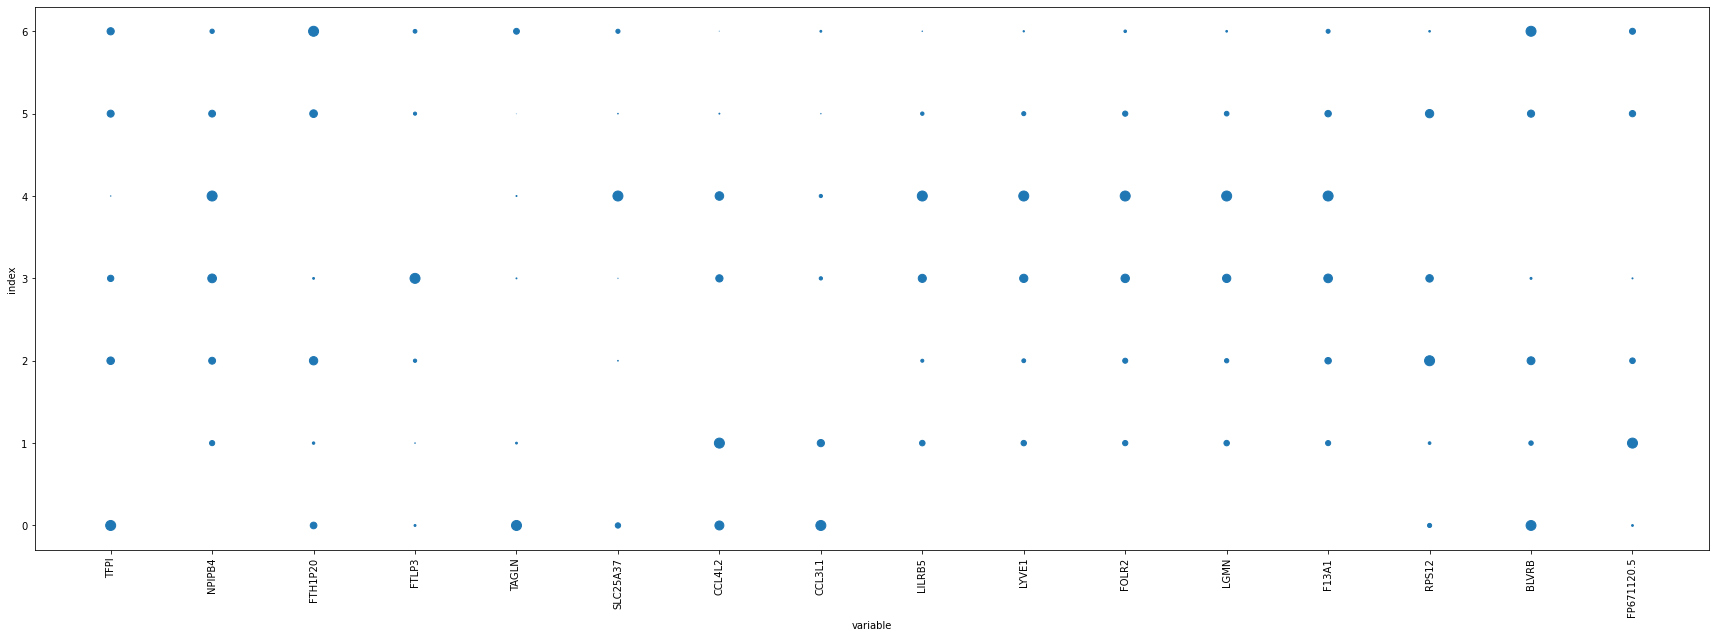

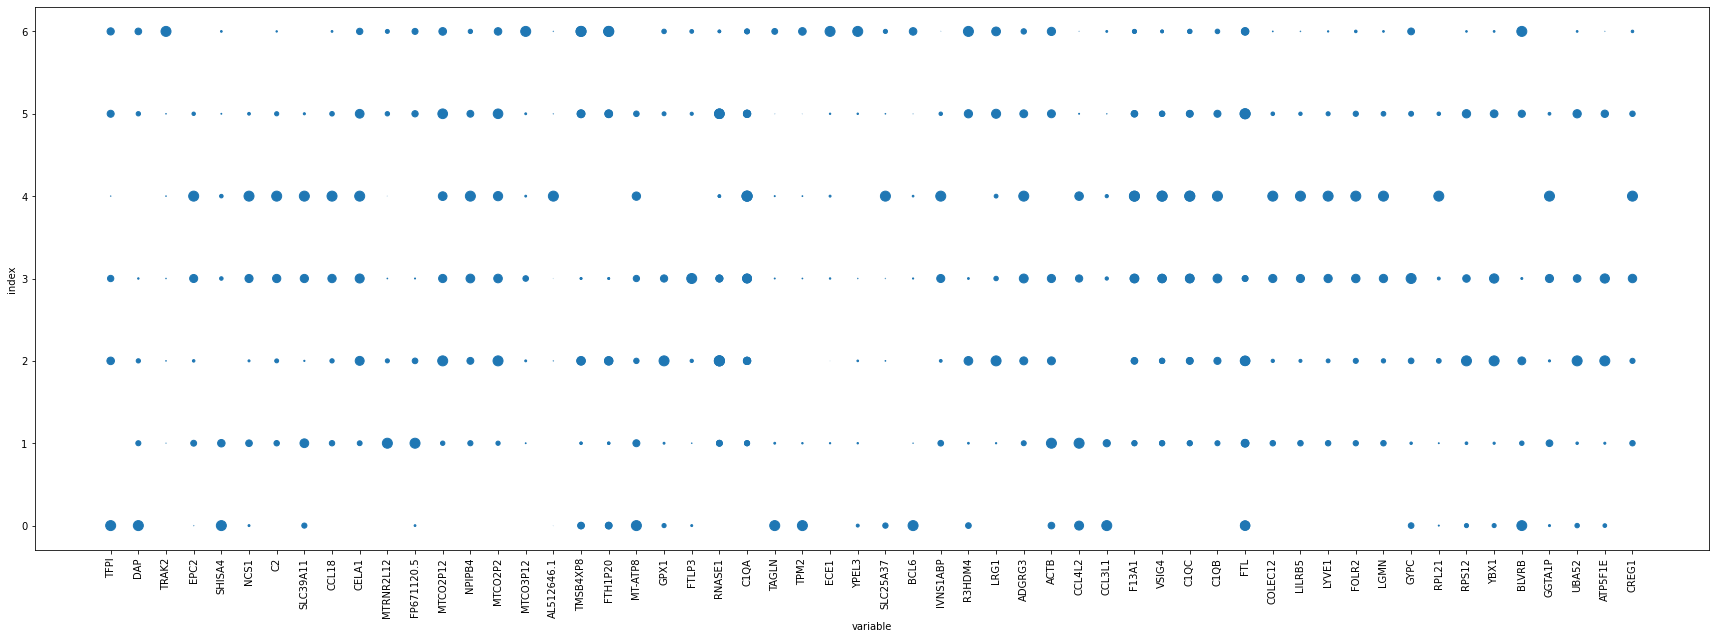

In [42]:
scaleit_best = scaleit[Markers_macrophage]
scaleit_low = scaleit[Binary_Markers_macrophage]
scaleit_best = pow(scaleit_best,2) * 100
scaleit_best.reset_index(inplace=True)
scaleit_melted_best = scaleit_best.melt(id_vars='index')
fig_scale_best = scaleit_melted_best.plot.scatter(x="variable", y="index", s="value", figsize=(30,10), rot=90)
#fig_scale_best.figure.savefig(f"output_{outdataname}_best.png")
scaleit_low = pow(scaleit_low,2) * 100
scaleit_low.reset_index(inplace=True)
scaleit_melted_low = scaleit_low.melt(id_vars='index')
fig_scale_low = scaleit_melted_low.plot.scatter(x="variable", y="index", s="value", figsize=(30,10), rot=90)
#fig_scale_low.figure.savefig(f"output_{outdataname}_low.png")

In [128]:
adata.obs.cell_ontology_class

cell_id
AAACGAACAGATCACT_TSP14_Vasculature_AortaVeneCava_10X_1_1          smooth muscle cell
AACAAGACAAAGGCGT_TSP14_Vasculature_AortaVeneCava_10X_1_1                  fibroblast
AACAGGGCACGTACTA_TSP14_Vasculature_AortaVeneCava_10X_1_1                  fibroblast
AACCAACAGTACCGGA_TSP14_Vasculature_AortaVeneCava_10X_1_1          smooth muscle cell
AACCACACATGTGGCC_TSP14_Vasculature_AortaVeneCava_10X_1_1                  macrophage
                                                                         ...        
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P3_S363      endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P4_S364      endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P5_S365      endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P8_S368      endothelial cell
TSP2_Vasculature_aorta_SS2_B114577_B133059_Endothelial_P9_S369      endothelial cell
Name: cell_ontology_class, Length: 2950, dtype: category


In [129]:
# https://github.com/JCVenterInstitute/NSForest
import graphviz
from NSForest_v3 import *

adata_markers = NS_Forest(adata, 'leiden')

23
0
TENT5C
2.0839321613311768
FTL
-0.19119572639465332
Is Right Out!
SPARC
-0.914479672908783
Is Right Out!
YBX3
-1.0384021997451782
Is Right Out!
XCL2
-0.22623783349990845
Is Right Out!
RPS12
0.527188777923584
TAGLN
-0.7332324385643005
Is Right Out!
TNS1
-0.7202188968658447
Is Right Out!
XCL1
-0.21724119782447815
Is Right Out!
TFPI
-0.6797476410865784
Is Right Out!
CD163
-0.4653428792953491
Is Right Out!
RNASE1
-0.6367978453636169
Is Right Out!
CTSB
-0.774615466594696
Is Right Out!
EPB41
-0.2663629353046417
Is Right Out!
BGN
-0.752291202545166
Is Right Out!
['TENT5C', 'RPS12']
3
1


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

GAS1
2.898411512374878
SFRP2
2.5472512245178223
CCDC80
2.2050912380218506
TNXB
2.4224798679351807
ABI3BP
2.462527275085449
PI16
2.628624439239502
ISM1
-0.20859095454216003
Is Right Out!
PRG4
-0.2352646440267563
Is Right Out!
PDGFRL
2.689387321472168
ADGRD1
-0.2088300585746765
Is Right Out!
PCOLCE2
2.079819679260254
NOX4
-0.26151788234710693
Is Right Out!
PTGIS
1.640824556350708
OGN
1.6336607933044434
PTGFR
-0.21497155725955963
Is Right Out!
['GAS1', 'SFRP2', 'CCDC80', 'TNXB', 'ABI3BP', 'PI16', 'PDGFRL', 'PCOLCE2', 'PTGIS', 'OGN']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

2
ZFP36L1
2.0175058841705322
A2M
2.240408420562744
S1PR1
2.4420506954193115
EPAS1
2.066378593444824
SLC2A3
2.3354578018188477
AQP1
2.0917532444000244
FP671120.5
1.9368174076080322
MTRNR2L12
2.4436755180358887
HBA1
-0.9325053095817566
Is Right Out!
PLVAP
2.2492995262145996
LIMS2
2.2253332138061523
AHNAK
1.8646931648254395
FTLP2
-0.5313979387283325
Is Right Out!
TMSB4XP4
-0.641554594039917
Is Right Out!
FTH1P20
-0.7530258893966675
Is Right Out!
['ZFP36L1', 'A2M', 'S1PR1', 'EPAS1', 'SLC2A3', 'AQP1', 'FP671120.5', 'MTRNR2L12', 'PLVAP', 'LIMS2', 'AHNAK']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

3
IGFBP2
2.108577013015747
ITGBL1
2.4122731685638428
TNFRSF11B
2.8956382274627686
CCN3
2.5243210792541504
DKK3
2.419060468673706
POSTN
2.447028636932373
SPARC
1.203887701034546
PPP1R14A
1.8185583353042603
BGN
1.5977516174316406
NDUFA4L2
2.303187847137451
ITGA8
2.306919813156128
TPM2
1.738810420036316
EFEMP1
1.6542309522628784
CDH13
2.404207468032837
SUGCT
-0.23836998641490936
Is Right Out!
['IGFBP2', 'ITGBL1', 'TNFRSF11B', 'CCN3', 'DKK3', 'POSTN', 'SPARC', 'PPP1R14A', 'BGN', 'NDUFA4L2', 'ITGA8', 'TPM2', 'EFEMP1', 'CDH13']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

4
PLVAP
2.4568095207214355
ACKR1
2.7409467697143555
VWF
2.2065377235412598
EMCN
2.787403106689453
RAMP3
2.5666747093200684
SH3BGRL2
2.8431153297424316
JAM2
3.2140603065490723
PECAM1
1.815039873123169
PLAT
2.0953140258789062
LIFR
2.380683422088623
OLFM1
2.5154638290405273
PALMD
2.6795530319213867
BGN
-0.8212220668792725
Is Right Out!
PREX2
-0.20881003141403198
Is Right Out!
LDB2
2.353970766067505
['PLVAP', 'ACKR1', 'VWF', 'EMCN', 'RAMP3', 'SH3BGRL2', 'JAM2', 'PECAM1', 'PLAT', 'LIFR', 'OLFM1', 'PALMD', 'LDB2']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

5
PLN
2.4308083057403564
CNN1
2.6879847049713135
MYH11
2.293644905090332
RAMP1
2.622136354446411
MYLK
2.1390936374664307
PPP1R14A
2.0203328132629395
CSRP1
1.78333580493927
SORBS1
2.327425003051758
TPM2
1.882488489151001
ACTA2
1.9080108404159546
ACTG2
2.7331931591033936
DES
-0.11630696803331375
Is Right Out!
LMOD1
2.05684232711792
RGS5
2.0859169960021973
ITGA8
2.4259841442108154
['PLN', 'CNN1', 'MYH11', 'RAMP1', 'MYLK', 'PPP1R14A', 'CSRP1', 'SORBS1', 'TPM2', 'ACTA2', 'ACTG2', 'LMOD1', 'RGS5', 'ITGA8']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

6
LYVE1
2.5538671016693115
LILRB5
3.020969867706299
F13A1
2.1237053871154785
C1QC
1.9979726076126099
C1QA
1.8931955099105835
COLEC12
2.676152467727661
FOLR2
2.309164047241211
VSIG4
2.073683023452759
RNASE1
1.5567854642868042
C1QB
1.842320442199707
MS4A6A
1.9701594114303589
CD163
1.905930519104004
MS4A4A
2.14859938621521
MS4A7
2.015584707260132
LGMN
1.8632118701934814
['LYVE1', 'LILRB5', 'F13A1', 'C1QC', 'C1QA', 'COLEC12', 'FOLR2', 'VSIG4', 'RNASE1', 'C1QB', 'MS4A6A', 'CD163', 'MS4A4A', 'MS4A7', 'LGMN']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

7
CCL3L1
2.4872395992279053
CD163
1.7947643995285034
CCL4L2
2.361971855163574
MS4A7
1.9581446647644043
CTSB
1.2572555541992188
PHACTR1
-0.288500040769577
Is Right Out!
VSIG4
1.5931344032287598
CSF1R
2.176915168762207
C1QA
1.5566771030426025
MS4A6A
1.650829553604126
LYVE1
-0.3093893826007843
Is Right Out!
MSR1
2.0162878036499023
C1QC
1.6006286144256592
ADAP2
2.275556802749634
F13A1
1.3800461292266846
['CCL3L1', 'CD163', 'CCL4L2', 'MS4A7', 'CTSB', 'VSIG4', 'CSF1R', 'C1QA', 'MS4A6A', 'MSR1', 'C1QC', 'ADAP2', 'F13A1']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

8
LGI4
3.8891491889953613
FAM162B
-0.17281842231750488
Is Right Out!
FHL5
3.225332260131836
CNR1
-0.18308931589126587
Is Right Out!
ITGA7
3.0553786754608154
TINAGL1
2.028148651123047
MRGPRF
2.944469451904297
ANGPT4
-0.15880218148231506
Is Right Out!
CCDC102B
-0.21002396941184998
Is Right Out!
RASL11A
3.01728892326355
MT1L
2.7651166915893555
AGT
-0.18282701075077057
Is Right Out!
A2M
1.2630174160003662
REM1
-0.17878574132919312
Is Right Out!
PARM1
2.9119858741760254
['LGI4', 'FHL5', 'ITGA7', 'TINAGL1', 'MRGPRF', 'RASL11A', 'MT1L', 'A2M', 'PARM1']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

9
FTL
1.1626973152160645
C1QB
2.0898985862731934
C1QA
2.0699548721313477
C1QC
2.1412949562072754
GGTA1P
2.5509464740753174
PLTP
2.0254359245300293
CREG1
1.7584788799285889
FOLR2
2.371302604675293
TMIGD3
-0.17312273383140564
Is Right Out!
F13A1
2.2475833892822266
MS4A6A
2.1172585487365723
ATP5F1E
1.0760952234268188
BLVRB
1.5906836986541748
RNASE1
1.5857994556427002
AKR1B1
2.07130765914917
['FTL', 'C1QB', 'C1QA', 'C1QC', 'GGTA1P', 'PLTP', 'CREG1', 'FOLR2', 'F13A1', 'MS4A6A', 'ATP5F1E', 'BLVRB', 'RNASE1', 'AKR1B1']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

10
CCDC80
2.29618501663208
C7
2.36012601852417
ALKAL2
-0.12163224071264267
Is Right Out!
SFRP2
2.52315354347229
AL583785.1
-0.15028159320354462
Is Right Out!
CHRDL1
-0.1683967560529709
Is Right Out!
NFIX
1.8786087036132812
ACTB
-0.6042413115501404
Is Right Out!
AC002546.1
-0.13670974969863892
Is Right Out!
INMT
0.06514032185077667
GXYLT2
-0.17356149852275848
Is Right Out!
TAGLN
-0.6816045045852661
Is Right Out!
LINC00632
-0.21352432668209076
Is Right Out!
FTL
0.5501640439033508
LINC01697
-0.13684818148612976
Is Right Out!
['CCDC80', 'C7', 'SFRP2', 'NFIX', 'INMT', 'FTL']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

11
AL512646.1
4.281282901763916
MTCO2P2
2.106220006942749
STAB1
2.1687800884246826
CSF1R
1.4199936389923096
NPIPB4
1.3969892263412476
FTH1P20
3.2593679428100586
FTH1P7
2.2779269218444824
TMEM52B
-0.09555396437644958
Is Right Out!
TMSB4XP8
2.6306324005126953
FTLP2
-0.10674827545881271
Is Right Out!
AC084871.2
-0.1082775816321373
Is Right Out!
MS4A4E
-0.11383014172315598
Is Right Out!
TGFBI
2.1075525283813477
RNA5SP151
-0.11654557287693024
Is Right Out!
FCGR2A
1.7767573595046997
['AL512646.1', 'MTCO2P2', 'STAB1', 'CSF1R', 'NPIPB4', 'FTH1P20', 'FTH1P7', 'TMSB4XP8', 'TGFBI', 'FCGR2A']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

12
MPZL2
4.30516242980957
ITLN1
5.892026901245117
GJA5
5.682370185852051
BMX
5.114979267120361
OTC
-0.07741871476173401
Is Right Out!
SELP
4.302134037017822
CRTAC1
3.8464672565460205
IGFBP3
2.932321071624756
EDN1
3.978125810623169
SULF1
2.2305588722229004
VWF
2.485419273376465
F5
-0.09444409608840942
Is Right Out!
CYP1A1
-0.06831146776676178
Is Right Out!
TBX1
0.054069120436906815
EFEMP1
1.7068474292755127
['MPZL2', 'ITLN1', 'GJA5', 'BMX', 'SELP', 'CRTAC1', 'IGFBP3', 'EDN1', 'SULF1', 'VWF', 'TBX1', 'EFEMP1']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

13
CPA3
6.142404556274414
TPSAB1
6.185080528259277
TPSB2
6.1995649337768555
RHEX
6.205288887023926
KIT
6.3044562339782715
MS4A2
6.680326461791992
CTSG
7.026243209838867
RGS13
7.316662311553955
HPGDS
4.967303276062012
SLC18A2
7.276015281677246
SIGLEC17P
-0.10573641955852509
Is Right Out!
LINC02207
-0.131855309009552
Is Right Out!
CDK15
-0.09617818146944046
Is Right Out!
NRCAM
-0.09464311599731445
Is Right Out!
NTM
-0.1240033507347107
Is Right Out!
['CPA3', 'TPSAB1', 'TPSB2', 'RHEX', 'KIT', 'MS4A2', 'CTSG', 'RGS13', 'HPGDS', 'SLC18A2']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

14
TMSB4XP8
3.817054033279419
FTLP3
4.011362075805664
C1QA
2.858480453491211
RNASE1
2.2908055782318115
C1QB
2.9220328330993652
FTH1P20
3.9213311672210693
FTLP2
5.79466438293457
CD163
2.5519466400146484
F13A1
2.9356348514556885
C1QC
2.9255905151367188
GPX1P1
5.5196757316589355
FTH1P8
4.60990047454834
VSIG4
2.973604440689087
GPX1
2.096282958984375
FTH1P23
4.713911533355713
['TMSB4XP8', 'FTLP3', 'C1QA', 'RNASE1', 'C1QB', 'FTH1P20', 'FTLP2', 'CD163', 'F13A1', 'C1QC', 'GPX1P1', 'FTH1P8', 'VSIG4', 'GPX1', 'FTH1P23']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

15
HBA1
6.548340797424316
HBB
6.369396686553955
HBA2
6.304770469665527
AC091492.1
-0.19345849752426147
Is Right Out!
ALAS2
6.771822929382324
AL136454.1
-0.316085547208786
Is Right Out!
GIMAP5
-0.3071545362472534
Is Right Out!
FTH1P23
-0.6654163002967834
Is Right Out!
SLC25A39
4.483083248138428
AC092634.5
-0.10991639643907547
Is Right Out!
FTLP3
-0.9601947069168091
Is Right Out!
AL080250.1
-0.127217099070549
Is Right Out!
AC008817.1
-0.1481272131204605
Is Right Out!
TXNP4
-0.06564664095640182
Is Right Out!
MRPS24
-0.23783130943775177
Is Right Out!
['HBA1', 'HBB', 'HBA2', 'ALAS2', 'SLC25A39']
31


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

16
ADGRD1
3.6696372032165527
ABI3BP
3.2196972370147705
PDGFRL
3.0918455123901367
ANXA2P2
3.7333762645721436
SLIT2
2.8254947662353516
FTH1P20
2.2691152095794678
CCDC80
2.3264079093933105
PI16
1.6561129093170166
NOX4
2.8287150859832764
SFRP2
2.586611270904541
RPL41P1
3.3028900623321533
GAS1
2.073333978652954
PROCR
2.3061861991882324
AC136424.2
-0.08006033301353455
Is Right Out!
ABLIM1
1.5160192251205444
['ADGRD1', 'ABI3BP', 'PDGFRL', 'ANXA2P2', 'SLIT2', 'FTH1P20', 'CCDC80', 'PI16', 'NOX4', 'SFRP2', 'RPL41P1', 'GAS1', 'PROCR', 'ABLIM1']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

17
ANGPTL7
7.287232875823975
SLC2A1
4.279052734375
BNC2
3.403001308441162
MEOX2
4.219064712524414
PRICKLE1
-0.14836184680461884
Is Right Out!
FOXD1
4.694240570068359
PDZRN4
-0.11419753730297089
Is Right Out!
SLC22A3
-0.13787323236465454
Is Right Out!
FLRT2
3.856074333190918
PTCH1
-0.19233235716819763
Is Right Out!
FIBIN
3.119428873062134
ENTPD2
-0.06500466912984848
Is Right Out!
USP54
-0.15013863146305084
Is Right Out!
ACADL
4.22127103805542
MATN2
3.8117594718933105
['ANGPTL7', 'SLC2A1', 'BNC2', 'MEOX2', 'FOXD1', 'FLRT2', 'FIBIN', 'ACADL', 'MATN2']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

18
TCEAL2
4.798391819000244
F2R
2.990661144256592
EDIL3
3.2677299976348877
FMOD
2.7843575477600098
TMEM56
-0.12978065013885498
Is Right Out!
LTBP2
2.5365946292877197
LIMCH1
2.765272378921509
CRISPLD1
5.237390518188477
CPAMD8
-0.11886715888977051
Is Right Out!
PRKG1
2.9670305252075195
LTBP1
2.3417835235595703
GUCY1A1
3.035332441329956
FOXC2
4.588110446929932
DKK3
2.7433981895446777
COMP
-0.19650688767433167
Is Right Out!
['TCEAL2', 'F2R', 'EDIL3', 'FMOD', 'LTBP2', 'LIMCH1', 'CRISPLD1', 'PRKG1', 'LTBP1', 'GUCY1A1', 'FOXC2', 'DKK3']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

19
ADGRG3
8.203261375427246
PHACTR1
3.895615577697754
OSM
4.915651321411133
IVNS1ABP
2.8005080223083496
LRG1
4.8168230056762695
AZIN1-AS1
4.416984558105469
SLC25A37
2.1207680702209473
USP10
2.9158246517181396
YPEL3
1.7862143516540527
MYO7B
-0.0812307745218277
Is Right Out!
R3HDM4
2.8167550563812256
BCL6
1.968923807144165
TNFRSF10C
-0.093437060713768
Is Right Out!
SLC6A6
3.3041257858276367
AC106028.4
-0.06972090154886246
Is Right Out!
['ADGRG3', 'PHACTR1', 'OSM', 'IVNS1ABP', 'LRG1', 'AZIN1-AS1', 'SLC25A37', 'USP10', 'YPEL3', 'R3HDM4', 'BCL6', 'SLC6A6']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

20
AC131235.1
3.475571632385254
PIP4K2A
2.499988555908203
RPL15P3
3.8407137393951416
RPL21P75
3.945432662963867
RPS3AP26
3.1436920166015625
BX679664.1
4.1472487449646
RPS3AP47
3.1640024185180664
RPS18P12
2.9352447986602783
RPL21P16
4.069155693054199
EEF1A1P6
3.5023953914642334
AC002075.2
1.780666470527649
RPL7P1
3.41019344329834
RPL41P1
3.8211331367492676
XCL1
-0.18246406316757202
Is Right Out!
TENT5C
0.6273289918899536
['AC131235.1', 'PIP4K2A', 'RPL15P3', 'RPL21P75', 'RPS3AP26', 'BX679664.1', 'RPS3AP47', 'RPS18P12', 'RPL21P16', 'EEF1A1P6', 'AC002075.2', 'RPL7P1', 'RPL41P1', 'TENT5C']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

21
RPS12
-2.042599678039551
Is Right Out!
RPL21
-2.0653676986694336
Is Right Out!
FTL
-1.1660009622573853
Is Right Out!
CARMN
3.3577346801757812
AC026124.1
-0.20756612718105316
Is Right Out!
ZDHHC1
-0.18300849199295044
Is Right Out!
ATP5F1E
-1.8033933639526367
Is Right Out!
DMD
2.3336076736450195
NAV2
2.616546392440796
GDI1
-0.503993034362793
Is Right Out!
NAV1
2.469573497772217
SPEG
3.610952377319336
PALD1
-0.25573283433914185
Is Right Out!
ADRA2B
-0.25000691413879395
Is Right Out!
RIN2
-0.6132012009620667
Is Right Out!
['CARMN', 'DMD', 'NAV2', 'NAV1', 'SPEG']
31


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

22
MZB1
9.23691177368164
FCRL5
9.565221786499023
SPAG4
8.032122611999512
DERL3
9.015342712402344
JCHAIN
10.0
TNFRSF17
9.612630844116211
IGLV3-1
10.0
IGKC
9.352753639221191
IGHA2
8.126570701599121
IGHA1
9.634683609008789
TNFRSF18
5.820693016052246
AC012236.1
0.1545531153678894
IGHG1
-0.08655206859111786
Is Right Out!
LINC01480
6.03541374206543
IGHG3
-0.2671656310558319
Is Right Out!
['MZB1', 'FCRL5', 'SPAG4', 'DERL3', 'JCHAIN', 'TNFRSF17', 'IGLV3-1', 'IGKC', 'IGHA2', 'IGHA1', 'TNFRSF18', 'AC012236.1', 'LINC01480']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

23
TPM2
2.52767014503479
AP005018.2
8.957655906677246
C12orf75
3.137477397918701
PPP1R14A
2.624213218688965
RGS5
3.0373566150665283
CAVIN3
0.3011802136898041
MRVI1
2.368462324142456
TNFRSF11B
-0.12452345341444016
Is Right Out!
FHL1
2.427149772644043
TAGLN
2.1936838626861572
ACTA2
2.474412679672241
MYH11
2.914046287536621
PALLD
2.3684465885162354
ACTG2
-0.15741224586963654
Is Right Out!
CCN3
-0.1354614496231079
Is Right Out!
['TPM2', 'AP005018.2', 'C12orf75', 'PPP1R14A', 'RGS5', 'CAVIN3', 'MRVI1', 'FHL1', 'TAGLN', 'ACTA2', 'MYH11', 'PALLD']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

                                                 index  f-measure  \
2    0&RPS12>=0.22041837126016617&TENT5C>=2.0700871...   0.660728   
1                          0&TENT5C>=2.070087194442749   0.639720   
0                         0&RPS12>=0.22041837126016617   0.301687   
16   1&TNXB>=1.9038432240486145&GAS1>=1.18529602885...   0.842993   
26   1&PTGIS>=1.1086581945419312&TNXB>=1.9038432240...   0.815558   
..                                                 ...        ...   
525  9&FOLR2>=2.0642908811569214&C1QA>=1.4690600037...   0.312500   
510                        9&FOLR2>=2.0642908811569214   0.298507   
527  9&C1QA>=1.4690600037574768&C1QB>=1.48582160472...   0.286511   
512                         9&C1QB>=1.4858216047286987   0.275629   
511                         9&C1QA>=1.4690600037574768   0.267355   

     True Negative  False Positive  False Negative  True Positive  \
2           2492.0            59.0           221.0          178.0   
1           2459.0            92.

In [130]:
adata_markers_raw = adata_markers

In [131]:
import itertools



Markers = list(itertools.chain.from_iterable(adata_markers['NSForest_Markers'])) #gets list of minimal markers from dataframe for display in scanpy plotting functions
Binary_Markers = list(itertools.chain.from_iterable(adata_markers['Binary_Genes'])) #gets list of binary markers from dataframe for display in scanpy plotting functions

for c, i in enumerate(Markers):
    if i not in Binary_Markers:
        print(f"{c} and {i}")
        
Markers.remove("AL512646-1")
Markers.append("AL512646.1")

7 and AL512646-1


In [132]:
import itertools

Markers = list()
for i in range(50):
    try:
        Markers.extend(adata_markers[adata_markers["clusterName"]==f"{i}"]["NSForest_Markers"])
    except:
        break
Markers = list(itertools.chain.from_iterable(Markers))
Binary_Markers = list()
for i in range(50):
    try:
        Binary_Markers.extend(adata_markers[adata_markers["clusterName"]==f"{i}"]["Binary_Genes"])
    except:
        break
Binary_Markers = list(itertools.chain.from_iterable(Binary_Markers))
        
Markers.remove("AL512646-1")
Markers.append("AL512646.1")
#Binary_Markers.remove("AL512646-1")
#Binary_Markers.append("AL512646.1")

In [133]:
for i,j in enumerate(adata_markers['NSForest_Markers']):
    print(f"{i} : {j}")

0 : ['RPS12', 'TENT5C']
1 : ['TNXB', 'GAS1']
2 : ['NFIX', 'CCDC80', 'FTL']
3 : ['AL512646-1']
4 : ['IGFBP3', 'MPZL2']
5 : ['CPA3']
6 : ['RNASE1', 'C1QB']
7 : ['HBA2']
8 : ['SLIT2', 'ADGRD1', 'ABI3BP', 'CCDC80']
9 : ['MATN2', 'SLC2A1']
10 : ['FMOD', 'LIMCH1', 'LTBP2', 'F2R']
11 : ['SLC25A37', 'IVNS1ABP', 'PHACTR1']
12 : ['A2M', 'S1PR1']
13 : ['PIP4K2A', 'RPS3AP47', 'RPS18P12']
14 : ['DMD', 'CARMN']
15 : ['MZB1']
16 : ['C12orf75', 'PPP1R14A']
17 : ['POSTN', 'PPP1R14A']
18 : ['PECAM1', 'LIFR', 'PLVAP', 'VWF', 'RAMP3']
19 : ['CNN1', 'SORBS1', 'PLN']
20 : ['COLEC12', 'LILRB5', 'RNASE1', 'LYVE1', 'C1QB']
21 : ['CTSB', 'CCL4L2', 'CCL3L1']
22 : ['A2M', 'MT1L']
23 : ['CREG1', 'GGTA1P']


In [134]:
for i,j in enumerate(adata_markers['Binary_Genes']):
    print(f"{i} : {j}")

0 : ['RPS12' 'TENT5C']
1 : ['PTGIS' 'TNXB' 'ABI3BP' 'PCOLCE2' 'GAS1' 'PI16' 'CCDC80' 'OGN' 'SFRP2'
 'PDGFRL']
2 : ['INMT' 'C7' 'NFIX' 'CCDC80' 'SFRP2' 'FTL']
3 : ['NPIPB4' 'CSF1R' 'STAB1' 'AL512646.1' 'MTCO2P2' 'TGFBI' 'FTH1P7' 'FCGR2A'
 'FTH1P20' 'TMSB4XP8']
4 : ['IGFBP3' 'VWF' 'CRTAC1' 'MPZL2' 'EDN1' 'SELP' 'SULF1' 'BMX' 'GJA5'
 'ITLN1']
5 : ['HPGDS' 'CPA3' 'TPSAB1' 'TPSB2' 'RHEX' 'KIT' 'MS4A2' 'CTSG' 'SLC18A2'
 'RGS13']
6 : ['RNASE1' 'FTLP2' 'C1QA' 'C1QB' 'F13A1' 'C1QC' 'CD163' 'FTLP3' 'FTH1P20'
 'TMSB4XP8']
7 : ['SLC25A39' 'HBA2' 'HBB' 'HBA1' 'ALAS2']
8 : ['PI16' 'NOX4' 'SLIT2' 'ADGRD1' 'ABI3BP' 'CCDC80' 'ANXA2P2' 'SFRP2'
 'PDGFRL' 'FTH1P20']
9 : ['BNC2' 'MATN2' 'FLRT2' 'SLC2A1' 'MEOX2' 'FIBIN' 'ACADL' 'FOXD1' 'ANGPTL7']
10 : ['FMOD' 'LIMCH1' 'LTBP2' 'EDIL3' 'F2R' 'LTBP1' 'GUCY1A1' 'PRKG1' 'TCEAL2'
 'CRISPLD1']
11 : ['YPEL3' 'SLC25A37' 'IVNS1ABP' 'USP10' 'PHACTR1' 'R3HDM4' 'AZIN1-AS1'
 'OSM' 'LRG1' 'ADGRG3']
12 : ['AQP1' 'SLC2A3' 'A2M' 'LIMS2' 'S1PR1' 'PLVAP' 'EPAS1' 'MTRNR2L12'
 '

In [135]:
adata_markers

clusterName  f-measure  markerCount  \
0            0   0.660728            2   
1            1   0.842993            2   
2           10   0.560472            3   
3           11   0.797101            1   
4           12   0.810185            2   
5           13   1.000000            1   
12          14   0.909091            2   
13          15   1.000000            1   
20          16   0.693431            4   
21          17   0.748031            2   
22          18   0.702479            4   
24          19   0.884615            3   
25           2   0.913295            2   
26          20   0.760870            3   
27          21   0.275229            2   
35          22   0.992908            1   
36          23   0.746269            2   
37           3   0.756430            2   
38           4   0.770270            5   
39           5   0.729013            3   
40           6   0.730181            5   
41           7   0.639640            3   
42           8   0.724907            2   
43           9   0.666667            2   

                          NSForest_Markers  True Positive  True Negative  \
0                          [RPS12, TENT5C]          178.0         2492.0   
1                             [TNXB, GAS1]          160.0         2683.0   
2                      [NFIX, CCDC80, FTL]           38.0         2817.0   
3                             [AL512646-1]           55.0         2849.0   
4                          [IGFBP3, MPZL2]           35.0         2874.0   
5                                   [CPA3]           74.0         2876.0   
12                          [RNASE1, C1QB]           42.0         2887.0   
13                                  [HBA2]           59.0         2891.0   
20         [SLIT2, ADGRD1, ABI3BP, CCDC80]           19.0         2898.0   
21                         [MATN2, SLC2A1]           19.0         2902.0   
22              [FMOD, LIMCH1, LTBP2, F2R]           17.0         2906.0   
24           [SLC25A37, IVNS1ABP, PHACTR1]           23.0         2912.0   
25                            [A2M, S1PR1]          158.0         2720.0   
26           [PIP4K2A, RPS3AP47, RPS18P12]           14.0         2914.0   
27                            [DMD, CARMN]           12.0         2885.0   
35                                  [MZB1]           28.0         2921.0   
36                    [C12orf75, PPP1R14A]           10.0         2926.0   
37                       [POSTN, PPP1R14A]          100.0         2716.0   
38       [PECAM1, LIFR, PLVAP, VWF, RAMP3]          114.0         2711.0   
39                     [CNN1, SORBS1, PLN]           99.0         2718.0   
40  [COLEC12, LILRB5, RNASE1, LYVE1, C1QB]          105.0         2741.0   
41                  [CTSB, CCL4L2, CCL3L1]           71.0         2754.0   
42                             [A2M, MT1L]           78.0         2769.0   
43                         [CREG1, GGTA1P]           48.0         2821.0   

    False Positive  False Negative           1         2         3       4  \
0             59.0           221.0       RPS12    TENT5C                     
1             14.0            93.0        TNXB      GAS1                     
2             18.0            77.0        NFIX    CCDC80       FTL           
3              8.0            38.0  AL512646-1                               
4              0.0            41.0      IGFBP3     MPZL2                     
5              0.0             0.0        CPA3                               
12             0.0            21.0      RNASE1      C1QB                     
13             0.0             0.0        HBA2                               
20             3.0            30.0       SLIT2    ADGRD1    ABI3BP  CCDC80   
21             1.0            28.0       MATN2    SLC2A1                     
22             3.0            24.0        FMOD    LIMCH1     LTBP2     F2R   
24             0.0            15.0    SLC25A37  IVNS1ABP   PHACTR1           
25             1.0            71.0   

In [136]:
import matplotlib.pyplot as plt
import pandas as pd

dotplot_values = pd.read_csv("NSForest3_medianValues.csv")
#ordered_cluster = [0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,3,4,5,6,7,8,9]
#dotplot_values["Cluster"] = ordered_cluster
dotplot_values.rename(columns = {'Unnamed: 0': "Cluster"}, inplace= True)
dotplot_values.set_index('Cluster', inplace=True)
dotplot_values

WASH7P  AL627309.6  AL627309.7    WASH9P  AL732372.2  AL669831.3  \
Cluster                                                                       
0       -0.096886   -0.039663   -0.023583 -0.061700   -0.055463   -0.046553   
1       -0.057308   -0.042984   -0.008143 -0.043564   -0.066616   -0.043651   
2       -0.300396   -0.057878   -0.077344 -0.177582   -0.072124   -0.045614   
3       -0.097072   -0.032056   -0.028911 -0.051901   -0.039899   -0.049938   
4       -0.042231   -0.042600   -0.003343 -0.036465   -0.067447   -0.043180   
5       -0.087287   -0.042799   -0.012480 -0.056236   -0.068174   -0.043220   
6       -0.069854   -0.049334   -0.006589 -0.059924   -0.078174   -0.041279   
7       -0.074798   -0.048180   -0.006864 -0.059080   -0.074356   -0.041514   
8       -0.059199   -0.043344   -0.005660 -0.048376   -0.067803   -0.043114   
9       -0.155948   -0.049485   -0.029165 -0.098102   -0.070868   -0.043915   
10      -0.116143   -0.045530   -0.025619 -0.076435   -0.064162   -0.044805   
11      -0.120300   -0.034591   -0.033625 -0.059313   -0.045347   -0.049180   
12      -0.066403   -0.042877   -0.016863 -0.047329   -0.064977   -0.044831   
13      -0.111293   -0.043095   -0.024085 -0.071638   -0.062127   -0.045458   
14      -0.291063   -0.053019   -0.074912 -0.171770   -0.062840   -0.048031   
15      -0.378127   -0.051449   -0.111149 -0.214911   -0.050206   -0.052168   
16      -0.104408   -0.039553   -0.033676 -0.063983   -0.056547   -0.046247   
17      -0.069729   -0.043705   -0.010619 -0.050524   -0.068303   -0.043411   
18      -0.072755   -0.038137   -0.015226 -0.047083   -0.054308   -0.046508   
19      -0.119470   -0.050013   -0.016599 -0.087665   -0.075133   -0.041349   
20      -0.111998   -0.032053   -0.035026 -0.064312   -0.037194   -0.050936   
21      -0.038132   -0.089070    0.040297 -0.068361   -0.159372   -0.022444   
22      -0.281946    0.001099   -0.116622 -0.099418    0.047026   -0.072165   
23      -0.258450   -0.030445   -0.083917 -0.120261   -0.024778   -0.055906   

         MTND2P28  MTCO2P12  MTATP8P1  MTCO3P12  ...     MT-TA     MT-TN  \
Cluster                                          ...                       
0       -0.254558 -0.132478 -0.031314 -0.187367  ... -0.157518 -0.175393   
1       -0.169336 -0.059074 -0.031223 -0.133158  ... -0.245494 -0.270042   
2       -0.459922 -0.632495 -0.149284 -0.637420  ... -0.192961 -0.179937   
3       -0.188553 -0.082807 -0.007836 -0.142423  ... -0.041162 -0.056742   
4       -0.110961 -0.028425 -0.026011 -0.104707  ... -0.266303 -0.297655   
5       -0.226275 -0.109700 -0.038116 -0.167360  ... -0.189827 -0.177054   
6       -0.277694 -0.140731 -0.056752 -0.203839  ... -0.319090 -0.352774   
7       -0.250744 -0.125053 -0.049834 -0.192228  ... -0.274818 -0.301545   
8       -0.154232 -0.065195 -0.034934 -0.125293  ... -0.214227 -0.225241   
9       -0.254361 -0.310831 -0.089524 -0.307509  ... -0.082551 -0.040284   
10      -0.332968 -0.208296 -0.054161 -0.246565  ... -0.166693 -0.170266   
11       0.425198  1.007646 -0.012824  1.602316  ... -0.093999 -0.102554   
12      -0.085458 -0.067514 -0.029146 -0.143199  ... -0.219654 -0.231953   
13      -0.269153 -0.146303 -0.040843 -0.207358  ... -0.200917 -0.208065   
14      -0.392904 -0.311281 -0.128952  2.075355  ... -0.127221 -0.104966   
15      -1.288203 -0.830282 -0.155384 -0.759372  ...  0.060421  0.109051   
16       0.526184 -0.074851 -0.028813  1.071186  ... -0.178759 -0.186750   
17      -0.222307 -0.093079 -0.036011 -0.163950  ... -0.232631 -0.263317   
18      -0.188426 -0.074728 -0.020414 -0.141269  ... -0.169011 -0.118568   
19      -0.510714 -0.281765 -0.090984 -0.317228  ... -0.170014 -0.221412   
20       0.451034  1.982643 -0.011324  2.490888  ... -0.043216 -0.039459   
21      -0.283770 -0.271141 -0.174709 -0.195524  ... -0.037831  3.275044   
22      -0.333453 -0.220747  0.052986 -0.222047  ...  0.570768  0.663295   
23      -0.254686 -0.330922 -0.034000  0.584925  ...  0.

In [137]:
from sklearn import preprocessing

minmaxscaler = preprocessing.MinMaxScaler()
x_scaled = minmaxscaler.fit_transform(dotplot_values)
scaleit = pd.DataFrame(x_scaled)
scaleit.columns = dotplot_values.columns
scaleit

WASH7P  AL627309.6  AL627309.7    WASH9P  AL732372.2  AL669831.3  \
0   0.827193    0.547942    0.592912  0.858588    0.503439    0.515100   
1   0.943601    0.511114    0.691309  0.960221    0.449402    0.573481   
2   0.228625    0.345932    0.250310  0.209192    0.422720    0.533989   
3   0.826645    0.632300    0.558958  0.913499    0.578846    0.447022   
4   0.987947    0.515370    0.721899  1.000000    0.445377    0.582941   
5   0.855426    0.513165    0.663671  0.889203    0.441855    0.582149   
6   0.906700    0.440689    0.701209  0.868537    0.393406    0.621189   
7   0.892159    0.453490    0.699455  0.873269    0.411905    0.616453   
8   0.938039    0.507121    0.707129  0.933252    0.443655    0.584284   
9   0.653477    0.439013    0.557337  0.654591    0.428803    0.568165   
10  0.770553    0.482879    0.579940  0.776011    0.461293    0.550264   
11  0.758327    0.604192    0.528917  0.871962    0.552454    0.462282   
12  0.916849    0.512301    0.635739  0.939119    0.457347    0.549736   
13  0.784819    0.509880    0.589711  0.802892    0.471155    0.537134   
14  0.256075    0.399819    0.265804  0.241763    0.467701    0.485381   
15  0.000000    0.417227    0.034876  0.000000    0.528912    0.402186   
16  0.805070    0.549161    0.528592  0.845790    0.498190    0.521269   
17  0.907067    0.503115    0.675525  0.921217    0.441228    0.578306   
18  0.898168    0.564869    0.646171  0.940500    0.509039    0.516011   
19  0.760767    0.433153    0.637418  0.713077    0.408140    0.619766   
20  0.782746    0.632336    0.519988  0.843946    0.591953    0.426949   
21  1.000000    0.000000    1.000000  0.821257    0.000000    1.000000   
22  0.282890    1.000000    0.000000  0.647217    1.000000    0.000000   
23  0.351997    0.650168    0.208420  0.530415    0.652112    0.327010   

    MTND2P28  MTCO2P12  MTATP8P1  MTCO3P12  ...     MT-TA     MT-TN     MT-TC  \
0   0.569694  0.248070  0.629768  0.175987  ...  0.181570  0.048895  0.386794   
1   0.616664  0.274166  0.630168  0.192666  ...  0.082705  0.022805  0.320254   
2   0.456508  0.070313  0.111665  0.037521  ...  0.141740  0.047642  0.307773   
3   0.606073  0.265729  0.732882  0.189815  ...  0.312329  0.081601  0.473636   
4   0.648837  0.285062  0.653057  0.201419  ...  0.059320  0.015194  0.312615   
5   0.585282  0.256168  0.599893  0.182143  ...  0.145262  0.048437  0.334095   
6   0.556943  0.245137  0.518049  0.170920  ...  0.000000  0.000000  0.252718   
7   0.571796  0.250710  0.548430  0.174492  ...  0.049751  0.014121  0.271753   
8   0.624989  0.271990  0.613872  0.195086  ...  0.117842  0.035154  0.321865   
9   0.569802  0.184666  0.374122  0.139024  ...  0.265816  0.086137  0.427321   
10  0.526478  0.221117  0.529427  0.157774  ...  0.171260  0.050308  0.358566   
11  0.944342  0.653387  0.710971  0.726615  ...  0.252951  0.068973  0.460030   
12  0.662893  0.271165  0.639292  0.189577  ...  0.111744  0.033304  0.324903   
13  0.561650  0.243156  0.587920  0.169837  ...  0.132799  0.039889  0.358805   
14  0.493444  0.184506  0.200957  0.872154  ...  0.215617  0.068308  0.368118   
15  0.000000  0.000000  0.084875  0.000000  ...  0.426484  0.127301  0.451808   
16  1.000000  0.268557  0.640753  0.563204  ...  0.157700  0.045764  0.375958   
17  0.587469  0.262077  0.609142  0.183192  ...  0.097160  0.024659  0.319494   
18  0.606143  0.268601  0.677641  0.190171  ...  0.168655  0.064558  0.379331   
19  0.428513  0.194999  0.367706  0.136033  ...  0.167527  0.036210  0.275860   
20  0.958581  1.000000  0.717562  1.000000  ...  0.310020  0.086365  0.493706   
21  0.553594  0.198776  0.000000  0.173478  ...  0.316072  1.000000  0.000000   
22  0.526211  0.216691  1.000000  0.165318  ...  1.000000  0.280077  1.000000   
23  0.569623  0.177523  0.617973  0.413597  ...  0.471384  0.135290  0.577911   

      MT-CO1     MT-TK   MT-ATP8   MT-ND4L    MT-ND4    MT-ND6     MT-TP  
0   0.668542  0.130894  0.310414  0.682653  0.449817  

In [138]:
scaleit[Markers]

RPS12    TENT5C      TNXB      GAS1       A2M     S1PR1     POSTN  \
0   0.531639  0.622043  0.035299  0.022830  0.190325  0.361265  0.012516   
1   0.455303  0.086424  1.000000  1.000000  0.213250  0.403683  0.012522   
2   0.047650  0.009716  0.147806  0.117063  1.000000  1.000000  0.038991   
3   0.444756  0.061526  0.042494  0.022647  0.564306  0.355715  1.000000   
4   0.464285  0.091579  0.011400  0.000000  0.602632  0.798969  0.014754   
5   0.463209  0.081140  0.032948  0.019641  0.561290  0.367726  0.014299   
6   0.461231  0.087686  0.019407  0.013153  0.218648  0.390048  0.016317   
7   0.438829  0.087880  0.022833  0.015891  0.214206  0.377376  0.015302   
8   0.428718  0.088279  0.017034  0.008132  0.723335  0.398808  0.013401   
9   0.579316  0.062628  0.066897  0.051418  0.182179  0.279426  0.021132   
10  0.550377  0.065604  0.069595  0.084477  0.177737  0.324356  0.015925   
11  0.196207  0.057364  0.060687  0.040917  0.163778  0.298075  0.011854   
12  0.371995  0.075723  0.135825  0.010969  0.216742  0.850721  0.012499   
13  0.518846  0.070615  0.043700  0.030927  0.179788  0.334677  0.014458   
14  0.465630  0.013350  0.142789  0.108933  0.065808  0.112153  0.027073   
15  1.000000  1.000000  0.191672  0.152974  0.000000  0.000000  0.030813   
16  0.320077  0.062222  0.335307  0.754418  0.181940  0.337058  0.012418   
17  0.487800  0.082814  0.059732  0.011192  0.214272  0.390086  0.013234   
18  0.440765  0.081900  0.022138  0.012101  0.588607  0.385913  0.012891   
19  0.261667  0.076015  0.046291  0.036217  0.174554  0.326307  0.021362   
20  0.328522  0.287690  0.044199  0.029621  0.176990  0.338703  0.009701   
21  0.000000  0.141836  0.000000  0.000712  0.265018  0.422217  0.034204   
22  0.550083  0.711380  0.139768  0.094951  0.090139  0.134262  0.000000   
23  0.227548  0.000000  0.124804  0.089841  0.117739  0.157216  0.017225   

    PPP1R14A    PECAM1      LIFR  ...   PHACTR1   PIP4K2A  RPS3AP47  RPS18P12  \
0   0.016639  0.248313  0.089244  ...  0.018678  0.645539  0.081468  0.081348   
1   0.004182  0.280960  0.099477  ...  0.015813  0.026634  0.095000  0.093007   
2   0.096444  0.936272  0.057116  ...  0.022545  0.020168  0.034325  0.025964   
3   0.751704  0.248419  0.092629  ...  0.020504  0.020561  0.077172  0.079086   
4   0.000000  0.953432  1.000000  ...  0.015163  0.027355  0.099790  0.098525   
5   0.813889  0.254581  0.091960  ...  0.016769  0.027357  0.091064  0.086889   
6   0.015386  0.283305  0.091216  ...  0.015285  0.029428  0.096248  0.092115   
7   0.015012  0.284672  0.090347  ...  0.021162  0.029846  0.096163  0.091369   
8   0.685863  0.276590  0.097171  ...  0.015354  0.027590  0.099207  0.096506   
9   0.043756  0.212694  0.068608  ...  0.019377  0.030672  0.076385  0.069013   
10  0.026613  0.222977  0.081114  ...  0.017377  0.023947  0.079633  0.075942   
11  0.028465  0.217701  0.078048  ...  0.021743  0.024423  0.076032  0.070242   
12  0.010424  1.000000  0.107989  ...  0.016796  0.024833  0.087304  0.089476   
13  0.025482  0.231434  0.083474  ...  0.018566  0.029263  0.082436  0.077323   
14  0.092127  0.079933  0.025437  ...  0.023280  0.017530  0.046449  0.031332   
15  0.121768  0.000000  0.000000  ...  0.027916  0.078479  0.004354  0.000000   
16  0.019749  0.235237  0.085307  ...  0.019204  0.022404  0.080185  0.080624   
17  0.008963  0.270781  0.096168  ...  0.015408  0.025589  0.092835  0.090722   
18  0.563105  0.268067  0.096074  ...  0.017914  0.023202  0.088709  0.088221   
19  0.040902  0.771513  0.075451  ...  1.000000  0.028334  0.087452  0.082974   
20  0.019361  0.238974  0.085192  ...  0.022447  1.000000  1.000000  1.000000   
21  0.037157  0.292194  0.107243  ...  0.000000  0.049644  0.136753  0.112422   
22  0.043530  0.103430  0.058908  ...  0.051653  0.000000  0.000000  0.016245   
23  1.000000  0.112401  0.051112  ...  0.028485  0.012021  0.045368  0.043729   

         DMD     CARMN      MZB1  C12orf75  PPP1R14A  AL512646.1  
0   0.043283 

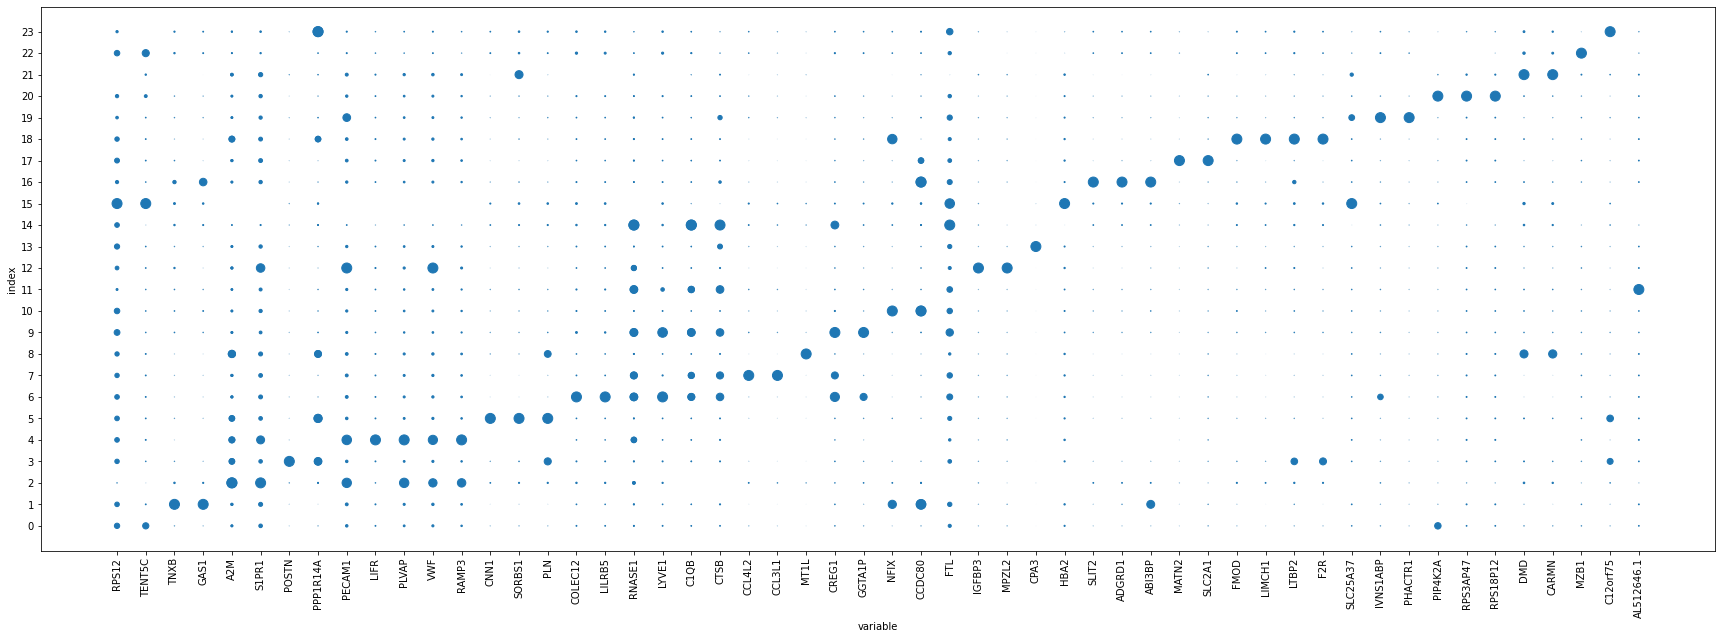

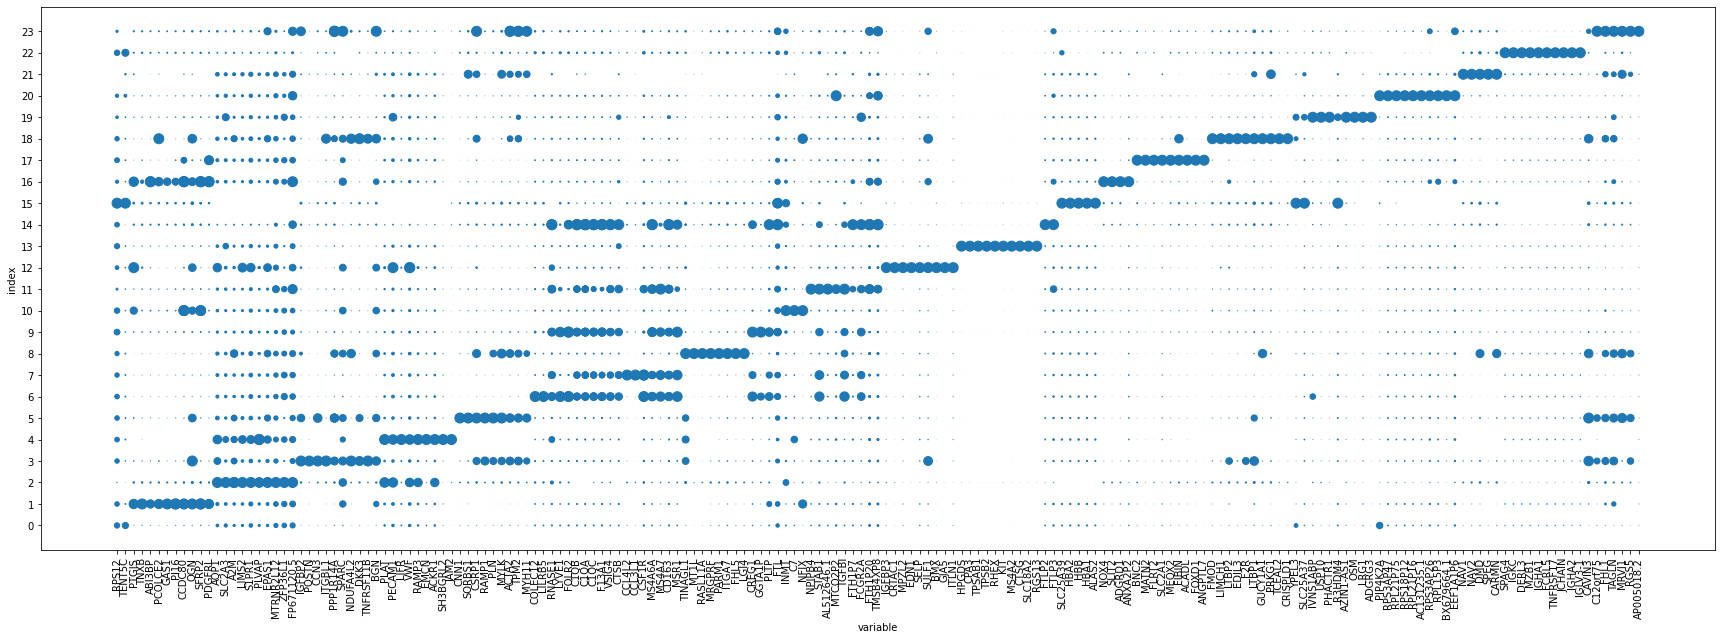

In [139]:
scaleit_best = scaleit[Markers]
scaleit_low = scaleit[Binary_Markers]
scaleit_best = pow(scaleit_best,2) * 100
scaleit_best.reset_index(inplace=True)
scaleit_melted_best = scaleit_best.melt(id_vars='index')
fig_scale_best = scaleit_melted_best.plot.scatter(x="variable", y="index", s="value", figsize=(30,10), rot=90, yticks=range(24))
fig_scale_best.figure.savefig(f"output_{outdataname}_best.png")
scaleit_low = pow(scaleit_low,2) * 100
scaleit_low.reset_index(inplace=True)
scaleit_melted_low = scaleit_low.melt(id_vars='index')
fig_scale_low = scaleit_melted_low.plot.scatter(x="variable", y="index", s="value", figsize=(30,10), rot=90, yticks=range(24))
fig_scale_low.figure.savefig(f"output_{outdataname}_low.png")

In [140]:
# TODO compare with scanpy tutorial
# https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html?msclkid=9d2e34bcd04011ecb94b3611e5706065

In [141]:
# https://github.com/JCVenterInstitute/NSForest
import graphviz
from NSForest_v3 import *

adata_markers = NS_Forest(adata, 'cell_ontology_class')

13
artery endothelial cell
MECOM
4.144496917724609
CX3CL1
-0.20647865533828735
Is Right Out!
NOTCH4
3.7590200901031494
PODXL
3.697614908218384
UQCC1
-0.18612892925739288
Is Right Out!
PALMD
3.114076614379883
BMPR2
2.0102410316467285
RAPGEF3
3.6586616039276123
IGFBP3
3.0002167224884033
NEDD9
1.9385066032409668
BMP6
-0.17506210505962372
Is Right Out!
MEF2C-AS2
-0.03149088844656944
Is Right Out!
GFOD1
-0.2604840099811554
Is Right Out!
HOXA3
-0.22692565619945526
Is Right Out!
MINDY1
-0.11896917968988419
Is Right Out!
['MECOM', 'NOTCH4', 'PODXL', 'PALMD', 'BMPR2', 'RAPGEF3', 'IGFBP3', 'NEDD9']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

b cell
IGLC2
-0.025382570922374725
Is Right Out!
NBR2
-0.13298103213310242
Is Right Out!
AC073896.4
-0.027979247272014618
Is Right Out!
ZNF846
-0.177548348903656
Is Right Out!
IGKC
0.05916208401322365
AC120193.1
-0.07331551611423492
Is Right Out!
IGHG3
-0.07473781704902649
Is Right Out!
PRDM4
-0.15892957150936127
Is Right Out!
AC005921.3
-0.10750181972980499
Is Right Out!
ZNF571
-0.1403188407421112
Is Right Out!
LINC01480
-0.11642596125602722
Is Right Out!
UGT2B17
-0.03203414008021355
Is Right Out!
PHACTR1
1.228943109512329
IGHA1
0.01117154210805893
CELSR1
-0.09166259318590164
Is Right Out!
['IGKC', 'PHACTR1', 'IGHA1']
7
endothelial cell


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

VWF
2.1799092292785645
ACKR1
2.3636555671691895
PLVAP
2.260662078857422
RAMP3
2.337632656097412
AQP1
1.7913081645965576
S1PR1
2.0239455699920654
PECAM1
1.8116573095321655
TSPAN7
2.1905174255371094
PLAT
1.9760453701019287
SLCO2A1
1.84933602809906
LDB2
2.0566017627716064
HYAL2
1.8590936660766602
LIMS2
1.678059697151184
EMCN
-0.19551941752433777
Is Right Out!
EPAS1
1.3921470642089844
['VWF', 'ACKR1', 'PLVAP', 'RAMP3', 'AQP1', 'S1PR1', 'PECAM1', 'TSPAN7', 'PLAT', 'SLCO2A1', 'LDB2', 'HYAL2', 'LIMS2', 'EPAS1']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

epithelial cell
PRG4
5.123137474060059
LGALS2
4.984118938446045
CLDN15
6.603078842163086
CRIM1-DT
6.001379489898682
IGHG4
8.080743789672852
SYT4
4.991300106048584
MST1
4.963397026062012
RAB17
10.0
JADE3
4.9622087478637695
RPS26P31
4.962751388549805
ITLN1
6.210226058959961
C4B
4.973324298858643
AC087521.3
4.982265949249268
PHYHIP
3.2503156661987305
NSUN4
1.6571606397628784
['PRG4', 'LGALS2', 'CLDN15', 'CRIM1-DT', 'IGHG4', 'SYT4', 'MST1', 'RAB17', 'JADE3', 'RPS26P31', 'ITLN1', 'C4B', 'AC087521.3', 'PHYHIP', 'NSUN4']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

erythrocyte
HBA1
6.543227195739746
HBB
6.349973678588867
HBA2
6.297982215881348
AC091492.1
-0.19291087985038757
Is Right Out!
ALAS2
6.767254829406738
AL136454.1
-0.3158935606479645
Is Right Out!
GIMAP5
-0.30635175108909607
Is Right Out!
FTH1P23
-0.6646833419799805
Is Right Out!
SLC25A39
4.469268798828125
AC092634.5
-0.10942050069570541
Is Right Out!
FTLP3
-0.9592186212539673
Is Right Out!
AL080250.1
-0.12697330117225647
Is Right Out!
AC008817.1
-0.14776021242141724
Is Right Out!
TXNP4
-0.06550168991088867
Is Right Out!
GNG10
-0.39821892976760864
Is Right Out!
['HBA1', 'HBB', 'HBA2', 'ALAS2', 'SLC25A39']
31


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

fibroblast
SFRP2
2.4920473098754883
CCDC80
2.1779565811157227
GAS1
2.536447048187256
PI16
-0.16863234341144562
Is Right Out!
PDGFRL
2.3807201385498047
ABI3BP
2.3262345790863037
TNXB
1.8088219165802002
ADGRD1
-0.21497496962547302
Is Right Out!
PRG4
-0.22827520966529846
Is Right Out!
ISM1
-0.22723650932312012
Is Right Out!
TSKU
-0.23981058597564697
Is Right Out!
NOX4
-0.24605663120746613
Is Right Out!
PCOLCE2
1.636627435684204
C7
-0.339580237865448
Is Right Out!
CHRDL1
-0.25836479663848877
Is Right Out!
['SFRP2', 'CCDC80', 'GAS1', 'PDGFRL', 'ABI3BP', 'TNXB', 'PCOLCE2']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

lymphatic endothelial cell
MMRN1
4.952833652496338
PLSCR4
2.8397459983825684
TCEAL2
4.351006031036377
SEMA3D
6.45064640045166
AC105942.1
-0.16007937490940094
Is Right Out!
ORC5
-0.1641460657119751
Is Right Out!
EPHB4
3.9488167762756348
OXGR1
-0.020632721483707428
Is Right Out!
ANAPC4
3.3079774379730225
IQCE
-0.217755526304245
Is Right Out!
RABGAP1
2.1571309566497803
TSPAN5
3.054227590560913
CC2D1B
4.474503993988037
FAM189A2
8.069005012512207
GNA14
-0.045980267226696014
Is Right Out!
['MMRN1', 'PLSCR4', 'TCEAL2', 'SEMA3D', 'EPHB4', 'ANAPC4', 'RABGAP1', 'TSPAN5', 'CC2D1B', 'FAM189A2']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

macrophage
CD163
1.8560309410095215
C1QC
1.9303061962127686
C1QB
1.7952423095703125
MS4A6A
1.893021821975708
C1QA
1.8174285888671875
VSIG4
1.9171020984649658
MS4A7
1.9266743659973145
F13A1
1.9437570571899414
FCGR2A
1.8448879718780518
MSR1
1.947256088256836
CTSB
1.3552049398422241
RNASE1
1.5181047916412354
STAB1
1.7798551321029663
FOLR2
1.9734163284301758
CSF1R
0.6513770818710327
['CD163', 'C1QC', 'C1QB', 'MS4A6A', 'C1QA', 'VSIG4', 'MS4A7', 'F13A1', 'FCGR2A', 'MSR1', 'CTSB', 'RNASE1', 'STAB1', 'FOLR2', 'CSF1R']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

mast cell
CPA3
6.134087562561035
TPSAB1
6.172076225280762
TPSB2
6.194369792938232
KIT
6.2935333251953125
RHEX
6.195075988769531
MS4A2
6.6727752685546875
CTSG
7.007952690124512
RGS13
7.269053936004639
HPGDS
4.951488494873047
SLC18A2
7.272736072540283
SIGLEC17P
-0.10932520776987076
Is Right Out!
LINC02207
-0.13304740190505981
Is Right Out!
CDK15
-0.09652526676654816
Is Right Out!
NRCAM
-0.09547573328018188
Is Right Out!
NTM
-0.1240033507347107
Is Right Out!
['CPA3', 'TPSAB1', 'TPSB2', 'KIT', 'RHEX', 'MS4A2', 'CTSG', 'RGS13', 'HPGDS', 'SLC18A2']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

nk cell
XCL2
4.623263835906982
XCL1
4.651724815368652
TNFRSF18
-0.12313679605722427
Is Right Out!
B3GNT7
-0.14522510766983032
Is Right Out!
SLFN13
-0.15978866815567017
Is Right Out!
AC243829.4
-0.14737138152122498
Is Right Out!
KLRC3
-0.09399905800819397
Is Right Out!
CCL3L1
1.83452308177948
CLDND1
1.393165946006775
ZNF571
-0.16965119540691376
Is Right Out!
YBX3
-1.0398907661437988
Is Right Out!
PIP4K2A
1.531206488609314
RBM38
-0.1587168276309967
Is Right Out!
SIGLEC17P
-0.1433715522289276
Is Right Out!
RASA2
-0.34400475025177
Is Right Out!
['XCL2', 'XCL1', 'CCL3L1', 'CLDND1', 'PIP4K2A']
31


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

pericyte cell
LGI4
3.7166285514831543
FAM162B
-0.17100054025650024
Is Right Out!
ITGA7
2.8055496215820312
FHL5
3.1249806880950928
CNR1
-0.1924019455909729
Is Right Out!
CCDC102B
-0.2076961100101471
Is Right Out!
RASL11A
-0.14109720289707184
Is Right Out!
PARM1
2.728318214416504
MYLK
1.9131011962890625
LINC00924
-0.15845490992069244
Is Right Out!
REM1
-0.16936472058296204
Is Right Out!
MRGPRF
0.07014953345060349
TINAGL1
1.96417236328125
TAGLN
1.5042343139648438
TPM2
1.5418853759765625
['LGI4', 'ITGA7', 'FHL5', 'PARM1', 'MYLK', 'MRGPRF', 'TINAGL1', 'TAGLN', 'TPM2']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

plasma cell
MZB1
9.23691177368164
FCRL5
9.565221786499023
SPAG4
8.032122611999512
DERL3
9.015342712402344
JCHAIN
10.0
TNFRSF17
9.612630844116211
IGLV3-1
10.0
IGKC
9.352753639221191
IGHA2
8.126570701599121
IGHA1
9.634683609008789
TNFRSF18
5.820693016052246
AC012236.1
0.1545531153678894
IGHG1
-0.08655206859111786
Is Right Out!
LINC01480
6.03541374206543
IGHG3
-0.2671656310558319
Is Right Out!
['MZB1', 'FCRL5', 'SPAG4', 'DERL3', 'JCHAIN', 'TNFRSF17', 'IGLV3-1', 'IGKC', 'IGHA2', 'IGHA1', 'TNFRSF18', 'AC012236.1', 'LINC01480']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

smooth muscle cell
TPM2
1.7257425785064697
PPP1R14A
1.8298884630203247
ACTA2
1.7545794248580933
ITGA8
2.2027573585510254
MYH11
1.920764446258545
PLN
1.9972831010818481
RAMP1
2.145689010620117
IGFBP2
1.6959800720214844
DKK3
2.1114158630371094
TAGLN
1.5169999599456787
MYLK
1.7388825416564941
TNFRSF11B
-0.25444936752319336
Is Right Out!
CNN1
1.6517459154129028
CCN3
2.157336473464966
PDLIM3
1.6467618942260742
['TPM2', 'PPP1R14A', 'ACTA2', 'ITGA8', 'MYH11', 'PLN', 'RAMP1', 'IGFBP2', 'DKK3', 'TAGLN', 'MYLK', 'CNN1', 'CCN3', 'PDLIM3']
63


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testArray['y_pred'] = 0
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

t cell
TENT5C
2.094442844390869
FTL
-0.2059745043516159
Is Right Out!
SPARC
-0.917247474193573
Is Right Out!
YBX3
-1.0394753217697144
Is Right Out!
RPS12
0.5346094369888306
TAGLN
-0.7321676015853882
Is Right Out!
TNS1
-0.7152619361877441
Is Right Out!
ATP6V0E2
-0.3105475604534149
Is Right Out!
CTSB
-0.7749789953231812
Is Right Out!
TFPI
-0.6757899522781372
Is Right Out!
GPX1
-0.9199746251106262
Is Right Out!
PIP4K2A
1.4085626602172852
RNASE1
-0.6384099125862122
Is Right Out!
PALLD
-0.66988205909729
Is Right Out!
CD163
-0.4592059552669525
Is Right Out!
['TENT5C', 'RPS12', 'PIP4K2A']
7


/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_store_DF = Binary_store_DF.append(binaryAndinformation_Ranks)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Binary_score_store_DF = Binary_score_store_DF.append(Binary_score_store_DF_extra)
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:122: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Subset_dataframe.columns = Subset_dataframe.columns.str.replace("-", "_").str.replace(".", "_")
/mnt/cip/home/c/cho/NEAP/NSForest/NSForest_v3.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy o

                                                 index  f-measure  \
39   artery endothelial cell&IGFBP3>=2.875912189483...   0.652174   
27   artery endothelial cell&NEDD9>=1.8191100955009...   0.571429   
31   artery endothelial cell&BMPR2>=2.1659222841262...   0.526316   
49   artery endothelial cell&NEDD9>=1.8191100955009...   0.526316   
26   artery endothelial cell&NEDD9>=1.8191100955009...   0.483871   
..                                                 ...        ...   
702  t cell&PIP4K2A>=1.3742387294769287&TENT5C>=2.0...   0.500589   
703  t cell&PIP4K2A>=1.3742387294769287&RPS12>=0.33...   0.448200   
705  t cell&PIP4K2A>=1.3742387294769287&TENT5C>=2.0...   0.425844   
699                 t cell&PIP4K2A>=1.3742387294769287   0.356993   
701                    t cell&RPS12>=0.338117852807045   0.268334   

     True Negative  False Positive  False Negative  True Positive  \
39          2939.0             0.0             8.0            3.0   
27          2937.0             2.

In [149]:
adata_markers_raw = adata_markers

Markers = list(itertools.chain.from_iterable(adata_markers['NSForest_Markers'])) #gets list of minimal markers from dataframe for display in scanpy plotting functions
Binary_Markers = list(itertools.chain.from_iterable(adata_markers['Binary_Genes'])) #gets list of binary markers from dataframe for display in scanpy plotting functions

for c, i in enumerate(Markers):
    if i not in Binary_Markers:
        print(f"{c} and {i}")

In [150]:
for i,j in enumerate(adata_markers['NSForest_Markers']):
    print(f"{i} : {j}")

0 : ['IGFBP3', 'RAPGEF3', 'NOTCH4']
1 : ['IGKC', 'PHACTR1']
2 : ['PLVAP']
3 : ['PRG4', 'CRIM1-DT']
4 : ['HBA2']
5 : ['SFRP2']
6 : ['CC2D1B', 'MMRN1']
7 : ['CD163']
8 : ['TPSAB1']
9 : ['CCL3L1', 'XCL1']
10 : ['TPM2', 'TINAGL1', 'ITGA7']
11 : ['MZB1']
12 : ['TPM2', 'DKK3']
13 : ['TENT5C']


In [151]:
for i,j in enumerate(adata_markers['Binary_Genes']):
    print(f"{i} : {j}")

0 : ['NEDD9' 'BMPR2' 'IGFBP3' 'PALMD' 'RAPGEF3' 'NOTCH4' 'MECOM' 'PODXL']
1 : ['IGHA1' 'IGKC' 'PHACTR1']
2 : ['PLAT' 'PECAM1' 'PLVAP' 'SLCO2A1' 'TSPAN7' 'AQP1' 'ACKR1' 'S1PR1' 'RAMP3'
 'VWF']
3 : ['PRG4' 'CRIM1-DT' 'CLDN15' 'MST1' 'RPS26P31' 'JADE3' 'IGHG4' 'LGALS2'
 'RAB17' 'SYT4']
4 : ['HBA2' 'SLC25A39' 'HBB' 'HBA1' 'ALAS2']
5 : ['PCOLCE2' 'SFRP2' 'TNXB' 'PDGFRL' 'ABI3BP' 'CCDC80' 'GAS1']
6 : ['RABGAP1' 'EPHB4' 'PLSCR4' 'CC2D1B' 'MMRN1' 'ANAPC4' 'TSPAN5' 'SEMA3D'
 'FAM189A2' 'TCEAL2']
7 : ['C1QB' 'C1QA' 'CD163' 'MS4A6A' 'FCGR2A' 'VSIG4' 'C1QC' 'F13A1' 'MS4A7'
 'MSR1']
8 : ['HPGDS' 'CPA3' 'TPSAB1' 'RHEX' 'TPSB2' 'KIT' 'MS4A2' 'CTSG' 'SLC18A2'
 'RGS13']
9 : ['CLDND1' 'CCL3L1' 'PIP4K2A' 'XCL2' 'XCL1']
10 : ['MRGPRF' 'TAGLN' 'TPM2' 'TINAGL1' 'MYLK' 'ITGA7' 'PARM1' 'FHL5' 'LGI4']
11 : ['SPAG4' 'DERL3' 'MZB1' 'IGKC' 'FCRL5' 'IGHA1' 'IGHA2' 'TNFRSF17' 'JCHAIN'
 'IGLV3-1']
12 : ['TAGLN' 'IGFBP2' 'TPM2' 'ACTA2' 'PPP1R14A' 'DKK3' 'RAMP1' 'ITGA8' 'MYH11'
 'PLN']
13 : ['PIP4K2A' 'TENT5C' 'RPS12'

In [152]:
dotplot_values = pd.read_csv("NSForest3_medianValues.csv")
dotplot_values.rename(columns = {'Unnamed: 0': "Cluster"}, inplace= True)
dotplot_values.set_index('Cluster', inplace=True)
dotplot_values

WASH7P  AL627309.6  AL627309.7    WASH9P  \
Cluster                                                                  
artery endothelial cell    -0.058388   -0.039285   -0.012694 -0.032054   
b cell                     -0.134349   -0.052258   -0.028432 -0.087845   
endothelial cell           -0.145161   -0.045129   -0.045137 -0.085144   
epithelial cell            -0.095200   -0.049758   -0.015520 -0.072962   
erythrocyte                -0.377844   -0.052406   -0.110787 -0.210541   
fibroblast                 -0.075380   -0.043132   -0.014287 -0.051822   
lymphatic endothelial cell -0.043479   -0.056541    0.018170 -0.050046   
macrophage                 -0.094742   -0.048380   -0.016344 -0.069343   
mast cell                  -0.110456   -0.043238   -0.023559 -0.070350   
nk cell                    -0.085650   -0.039570   -0.019874 -0.057560   
pericyte cell              -0.065019   -0.042590   -0.009812 -0.050535   
plasma cell                -0.281946    0.001099   -0.116622 -0.099418   
smooth muscle cell         -0.087548   -0.038967   -0.019414 -0.055163   
t cell                     -0.100201   -0.039056   -0.025643 -0.062198   

                            AL732372.2  AL669831.3  MTND2P28  MTCO2P12  \
Cluster                                                                  
artery endothelial cell      -0.058711   -0.045911 -0.134838 -0.036583   
b cell                       -0.074527   -0.043549 -0.445104 -0.253517   
endothelial cell             -0.068319   -0.044185 -0.114025 -0.117698   
epithelial cell              -0.076826   -0.041972 -0.389881 -0.203258   
erythrocyte                  -0.052094   -0.051763 -1.244222 -0.803730   
fibroblast                   -0.065424   -0.044332 -0.181201 -0.080016   
lymphatic endothelial cell   -0.099375   -0.035768 -0.233725 -0.097090   
macrophage                   -0.073061   -0.042766 -0.252546 -0.148037   
mast cell                    -0.062388   -0.045374 -0.269153 -0.154317   
nk cell                      -0.057097   -0.045977 -0.195080 -0.076072   
pericyte cell                -0.065618   -0.043936 -0.175091 -0.086014   
plasma cell                   0.047026   -0.072165 -0.333453 -0.220747   
smooth muscle cell           -0.056313   -0.046413 -0.202724 -0.096416   
t cell                       -0.051711   -0.047469 -0.246300 -0.126864   

                            MTATP8P1  MTCO3P12  ...     MT-TA     MT-TN  \
Cluster                                         ...                       
artery endothelial cell    -0.014548 -0.111142  ... -0.188466 -0.200092   
b cell                     -0.073911 -0.285486  ... -0.223875 -0.236363   
endothelial cell           -0.047308 -0.215135  ... -0.236508 -0.259458   
epithelial cell            -0.066159 -0.254647  ... -0.302316 -0.329266   
erythrocyte                -0.148568 -0.734596  ...  0.073797  0.074843   
fibroblast                 -0.034936 -0.146022  ... -0.214455 -0.229708   
lymphatic endothelial cell -0.065437 -0.166866  ... -0.306633 -0.340625   
macrophage                 -0.057894 -0.195431  ... -0.260546 -0.277627   
mast cell                  -0.043527 -0.208620  ... -0.201564 -0.211098   
nk cell                    -0.029343 -0.152526  ... -0.185264 -0.204669   
pericyte cell              -0.034075 -0.131661  ... -0.190827 -0.205032   
plasma cell                 0.052986 -0.222047  ...  0.570768  0.663295   
smooth muscle cell         -0.024399 -0.151820  ... -0.113377 -0.104523   
t cell                     -0.029080 -0.177374  ... -0.131829 -0.145925   

                               MT-TC    MT-CO1     MT-TK   MT-ATP8   MT-ND4L  \
Cluster                                                                        
artery endothelial cell    -0.119563 -0.173669 -0.182344 -0.437017 -0.674694   
b cell                     -0.119658  0.486699 -0.180892 -0.272297  0.356309   
endothelial cell           -0.165500  0.119798 -0.252199 -0.411005  0.485367   
epithelial cell            -0.209265  0.646384 -0.314473  0

In [153]:
minmaxscaler = preprocessing.MinMaxScaler()
x_scaled = minmaxscaler.fit_transform(dotplot_values)
scaleit = pd.DataFrame(x_scaled)
scaleit.columns = dotplot_values.columns
scaleit.index = dotplot_values.index
scaleit_best = scaleit[Markers]
scaleit_best = pow(scaleit_best,2) * 100
scaleit_best.reset_index(inplace=True)
scaleit_low = scaleit[Binary_Markers]
scaleit_low = pow(scaleit_low,2) * 100
scaleit_low.reset_index(inplace=True)

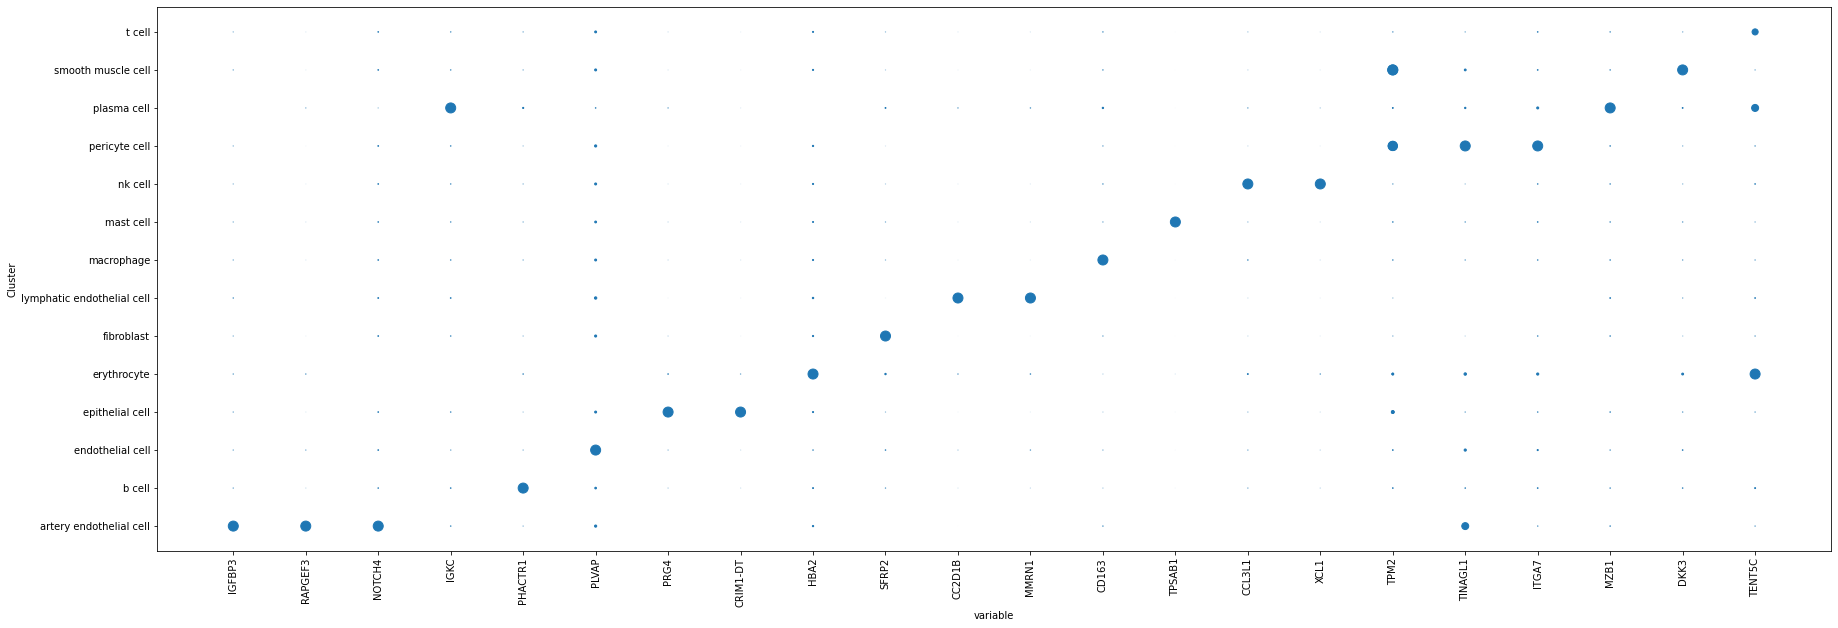

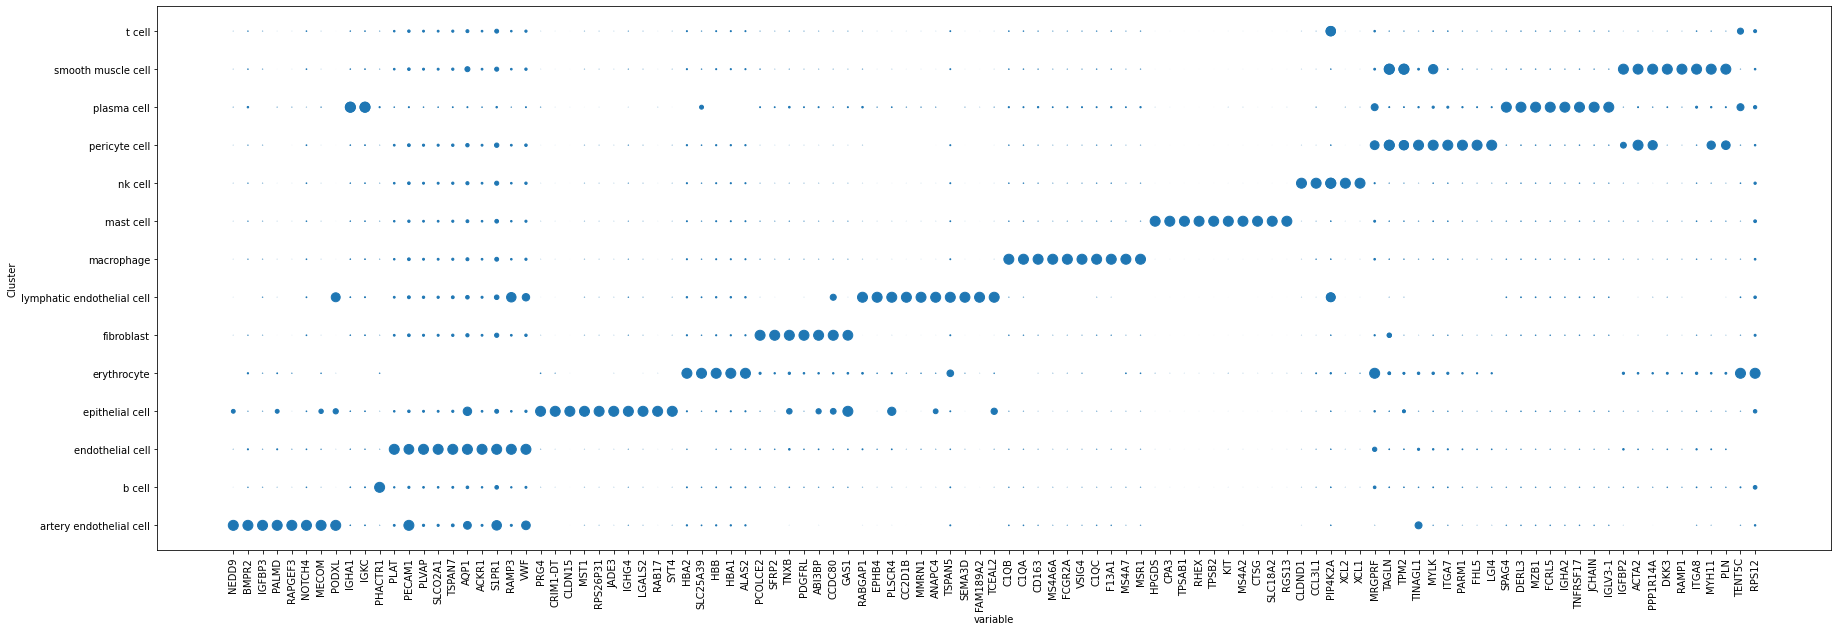

In [154]:
scaleit_melted = scaleit_best.melt(id_vars='Cluster')
fig_scale = scaleit_melted.plot.scatter(x="variable", y="Cluster", s="value", figsize=(30,10), rot=90)
fig_scale.figure.savefig(f"named_{outdataname}_best.png")
scaleit_melted = scaleit_low.melt(id_vars='Cluster')
fig_scale = scaleit_melted.plot.scatter(x="variable", y="Cluster", s="value", figsize=(30,10), rot=90)
fig_scale.figure.savefig(f"named_{outdataname}_low.png")